# Overview of perturbations with associated quintuplicate SEM (kcal/mol)

In [1]:
import glob
import csv
import re
import pandas as pd
import itertools
import numpy as np
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt 
import seaborn as sns 
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
from collections import defaultdict

from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.warning')
from rdkit.Chem import Draw, rdFMCS

from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor, rdmolfiles
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.image as mpimg

In [2]:
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])
quints_infos

,set,pertname,pertsmarts,num_ha,sem
0,TrainingSet,mobley_1662128~mobley_7047032,[C*]C~[C*]C.[C*]Cl,2,0.156846
1,TrainingSet,mobley_7047032~mobley_1662128,[C*]C.[C*]Cl~[C*]C,2,0.156846
2,TrainingSet,mobley_7015518~mobley_303222,[C*]OC~[C*]CC,1,0.108653
3,TrainingSet,mobley_303222~mobley_7015518,[C*]CC~[C*]OC,1,0.108653
4,TrainingSet,mobley_1046331~mobley_3515580,[C*]O~[C*]O,1,0.113167
...,...,...,...,...,...
5365,TrainingSet,mobley_5326154~mobley_1019269,[C*]N(C)C1CCCCC1~[C*]CCCO,8,0.155166
5366,TrainingSet,mobley_1019269~mobley_7774695,[C*]CCCO~[C*]NC1CCCCC1,7,0.119793
5367,TrainingSet,mobley_7774695~mobley_1019269,[C*]NC1CCCCC1~[C*]CCCO,7,0.119793
5368,TrainingSet,mobley_1019269~mobley_1189457,[C*]CCCO~[C*]SC1CCCCC1,7,0.281720


In [3]:
#Draw the molecule
def get_image(mol,atomset=None):    
    hcolor = colors.to_rgb('red')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img


def generateImages(mol,row,core,width=350,height=200,
                      fillRings=False,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=None):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
            
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    # loop over R groups.
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        try:
            rquery = row[lbl]
        # we don't know the number of R-groups, so just quit this loop if we've reached the end.
        except KeyError:
        	continue

        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,"",dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()

    # save to file:
    d2d.WriteDrawingText("tmp_imgs/"+legend+".png")
        
    return png

In [4]:
def plot_perts(quints_infos, precision=4):
    
    ligs_path = "./quintup_ligands/sdffiles/"

    for idx, pertinfo in quints_infos.iterrows():

        pert = pertinfo["pertname"]
        print(pert)
        
        ## get the paths to simulation folders on yoko
        with open("/home/jscheen/projects/HYDRA_LEARN/QUINTUP/COLLECTION/all_mbar_paths.txt", "r") as pathsfile:
            reader = csv.reader(pathsfile)
            for row in reader:
                if pert in row[0]:
                    print(row[0])
        
        ##


        ligA = Chem.SDMolSupplier(ligs_path+pert.split("~")[0]+".sdf")[0]
        ligB = Chem.SDMolSupplier(ligs_path+pert.split("~")[1]+".sdf")[0]

        mcs = rdFMCS.FindMCS([ligA, ligB], matchValences=False,
                                        ringMatchesRingOnly=True,
                                        completeRingsOnly=True,
                                        matchChiralTag=False)
        core = Chem.MolFromSmarts(mcs.smartsString)
        rdDepictor.Compute2DCoords(core)

        rdkit_mols = [ligA, ligB]
        # find subtructure matches with MCS per ligand, then tag matching atom indices in each ligand.
        ps = Chem.AdjustQueryParameters.NoAdjustments()
        ps.makeDummiesQueries=True
        qcore = Chem.AdjustQueryProperties(core,ps)
        #mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
        mms = [x for x in rdkit_mols if x.HasSubstructMatch(core)]
        for m in mms:
            for atom in m.GetAtoms():
                atom.SetIntProp("SourceAtomIdx",atom.GetIdx())

        # do an RDKit R-group decomposition.	
        groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

        # call the writer function with each molecule.
        ligand_names = [pert.split("~")[0], pert.split("~")[1]]
        #for i, m in enumerate(rdkit_mols):

        generateImages(rdkit_mols[0],groups[0],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                legend=ligand_names[0],
                                width=400,height=400)
        generateImages(rdkit_mols[1],groups[1],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                legend=ligand_names[1],
                                width=400,height=400)


        # now that this image is saved, load it into matplotlib for easier side-by-sde viewing.
        imgA = mpimg.imread("tmp_imgs/"+ligand_names[0]+".png")
        imgB = mpimg.imread("tmp_imgs/"+ligand_names[1]+".png")

        fig, axes = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 3, 1, 1]})
        axes[0].imshow(imgA)
        axes[1].imshow(imgB)

        # get some more pert info and annotate it.
        axes[2].annotate("    SEM:", xy=(0, 0.7), size=25)
        axes[3].annotate(round(pertinfo["sem"], 4), xy=(0, 0.7), size=25)

        axes[2].annotate("SMARTS:", xy=(0, 0.3), size=20)
        axes[3].annotate(pertinfo["pertsmarts"], xy=(0, 0.3), size=15)
        
        # get the five freenrg values that make up the SEM.
        perts_mbars = pd.read_csv("quintup_ligands/compiled_mbars_sofar.csv")
        try:
            mbar_vals = perts_mbars[perts_mbars["pert"] == pert][["freenrg_1", "freenrg_2", "freenrg_3", "freenrg_4", "freenrg_5"]].values[0]
        except IndexError:
            print("__________________________________________________________________________________________________________")
            continue
        
        for i, val in enumerate(mbar_vals):
            axes[3].annotate(round(float(val), precision), xy=(0, 0.6-(i*0.05)))
        axes[2].annotate("Constituents:", xy=(0, 0.5), size=20)


        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()
        print("__________________________________________________________________________________________________________")

# Highest 5 SEMs

mobley_1036761~mobley_4218209
./QUINTUP/30_dir_dir/finished/job_xbb/sim_3/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_1/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_5/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_4/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_2/mobley_1036761~mobley_4218209/free


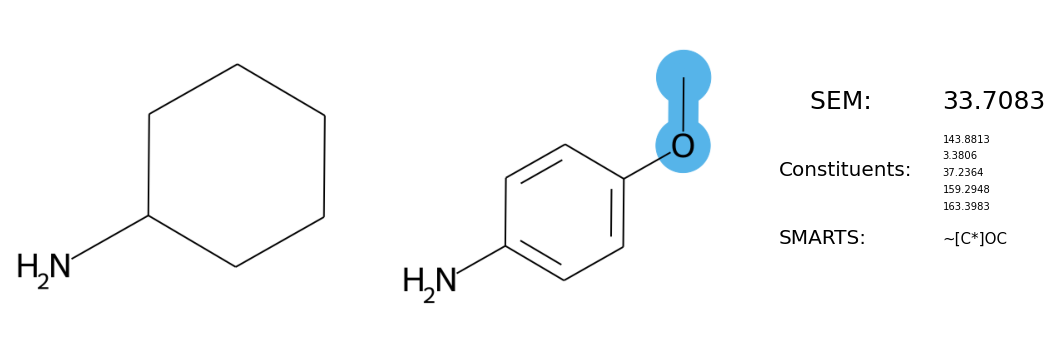

__________________________________________________________________________________________________________
mobley_4218209~mobley_1036761
mobley_1019269~mobley_4603202
./QUINTUP/25_dir_dir/round2/sim_376/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_378/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_379/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_380/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_377/mobley_1019269~mobley_4603202/free


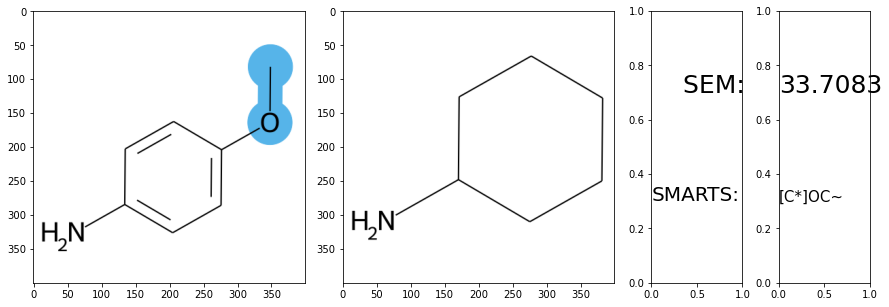

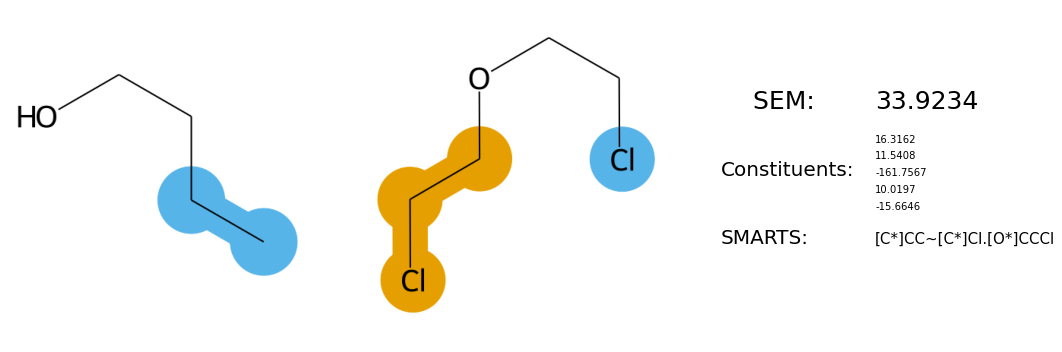

__________________________________________________________________________________________________________
mobley_4603202~mobley_1019269
mobley_2198613~mobley_627267
./QUINTUP/21_dir_dir/round1/sim_16354/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16353/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16355/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16351/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16352/mobley_2198613~mobley_627267/free


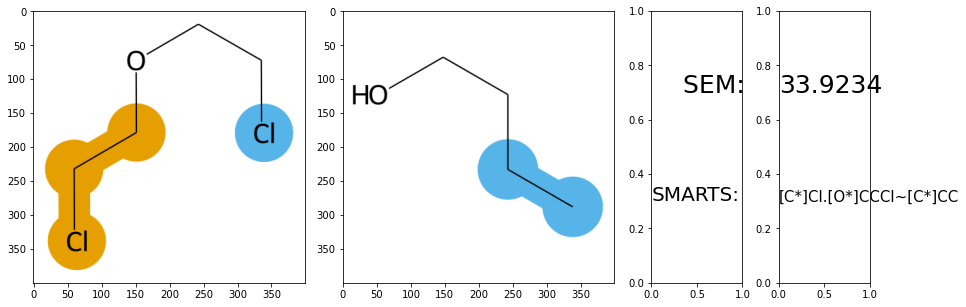

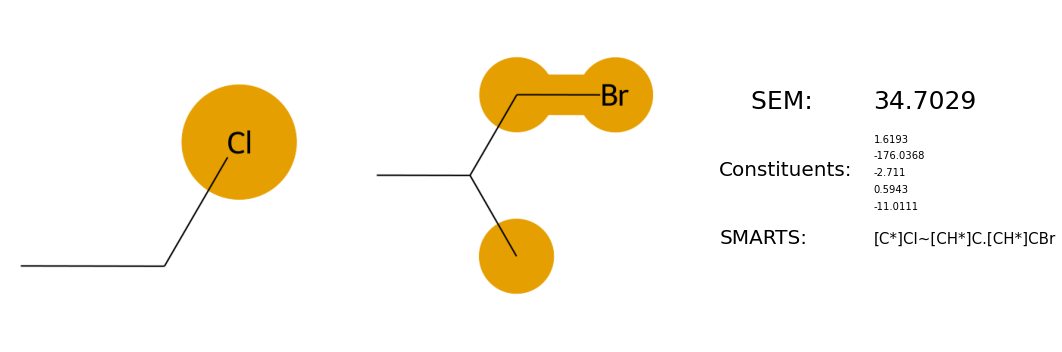

__________________________________________________________________________________________________________
mobley_627267~mobley_2198613
mobley_2859600~mobley_1036761
mobley_1036761~mobley_2859600
./QUINTUP/30_dir_dir/finished/job_xaz/sim_14/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_13/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_12/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_15/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_11/mobley_1036761~mobley_2859600/free


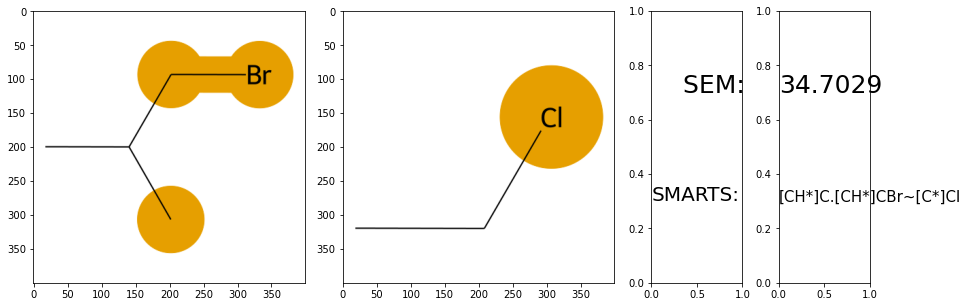

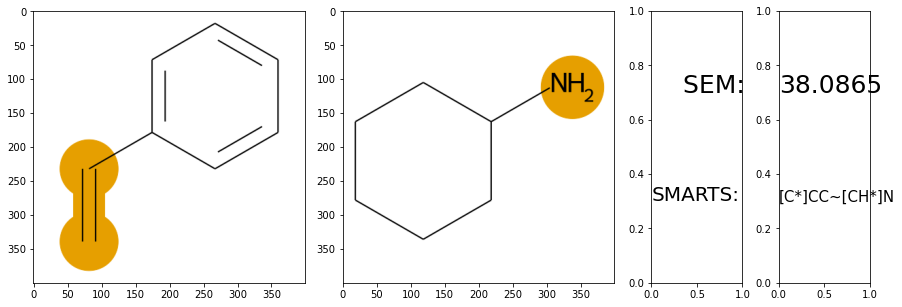

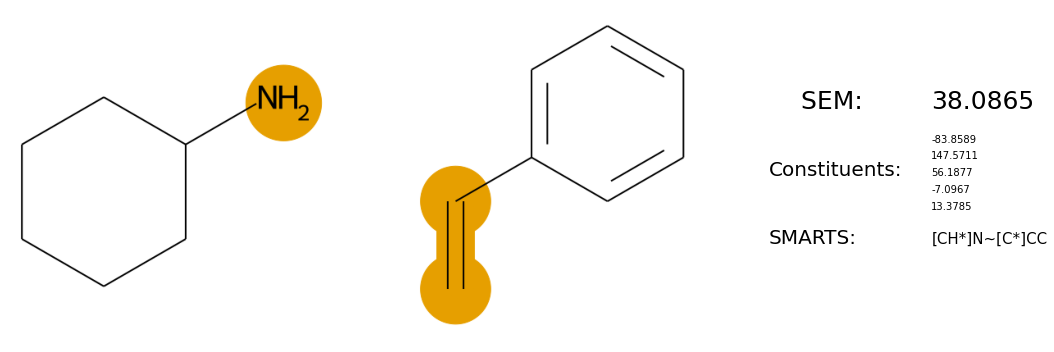

__________________________________________________________________________________________________________
mobley_1520842~mobley_8746821
./QUINTUP/30_dir_dir/finished/job_xgb/sim_18/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_20/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_17/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_19/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_16/mobley_1520842~mobley_8746821/free


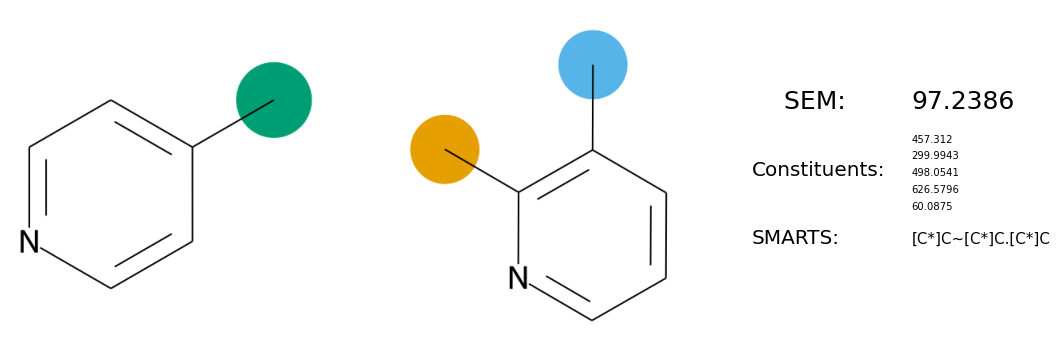

__________________________________________________________________________________________________________
mobley_8746821~mobley_1520842


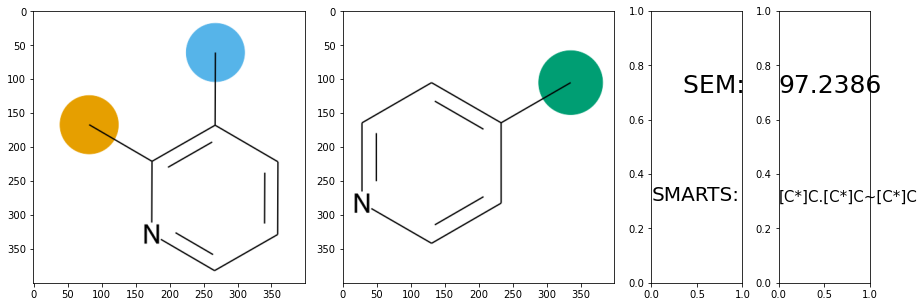

In [5]:
%matplotlib inline
plot_perts(quints_infos.sort_values(by="sem").tail(10))

# SEM == 0.0:

mobley_1231151~mobley_4305650
./QUINTUP/29_dir_dir/finished/job_xbs/sim_18/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_20/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_17/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_19/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_16/mobley_1231151~mobley_4305650/free


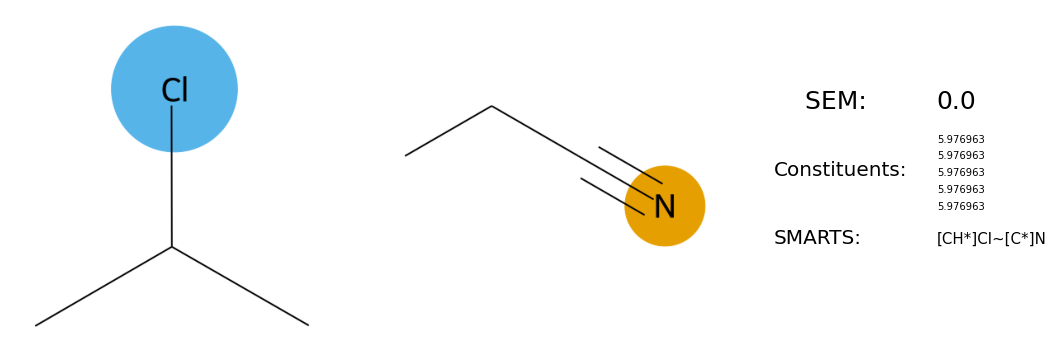

__________________________________________________________________________________________________________
mobley_4305650~mobley_1231151
mobley_9257453~mobley_7988076
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_14/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_13/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_12/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_15/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_11/mobley_9257453~mobley_7988076/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_14/mobley_9257453~mobley_7988076/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_13/mobley_9257453~mobley_7988076/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_12/mobl

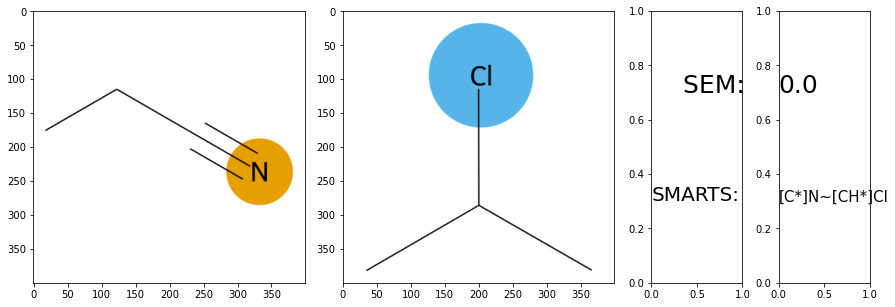

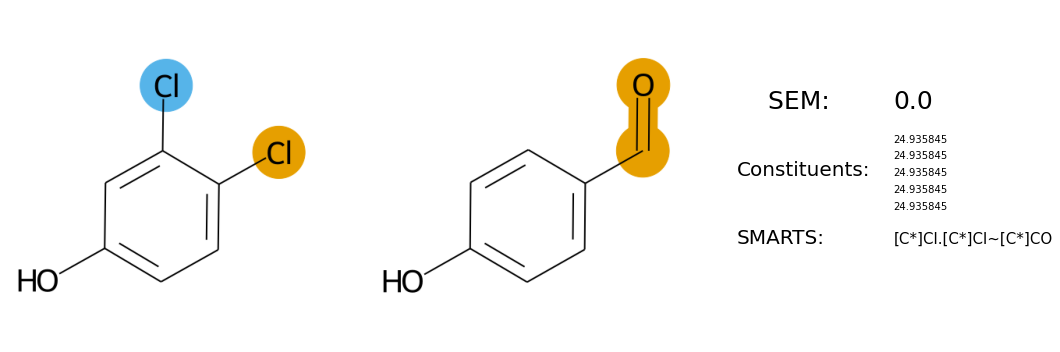

__________________________________________________________________________________________________________
mobley_7988076~mobley_9257453
mobley_9913368~mobley_4305650
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_3/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_1/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_5/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_4/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_2/mobley_9913368~mobley_4305650/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_3/mobley_9913368~mobley_4305650/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_1/mobley_9913368~mobley_4305650/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_5/mobley_99133

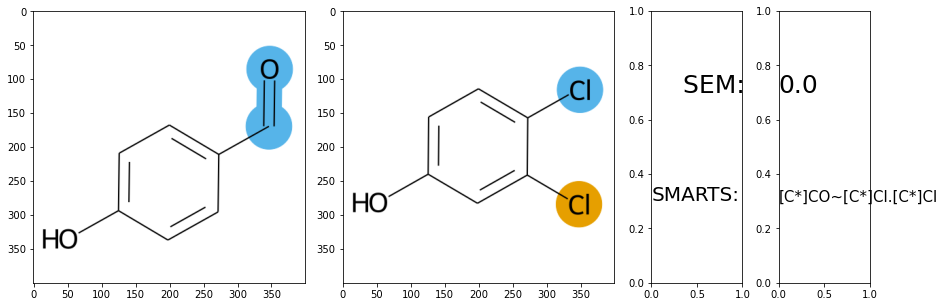

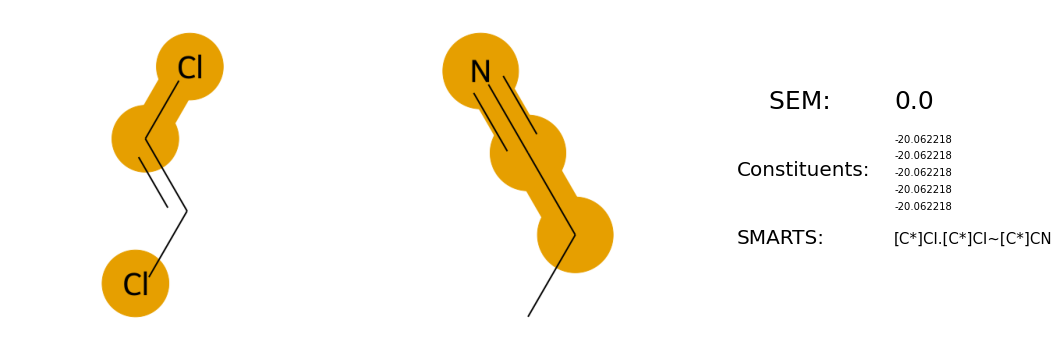

__________________________________________________________________________________________________________
mobley_4305650~mobley_9913368
mobley_1178614~mobley_7066554
./QUINTUP/29_dir_dir/finished/job_xbh/sim_7/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_9/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_8/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_6/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_10/mobley_1178614~mobley_7066554/free


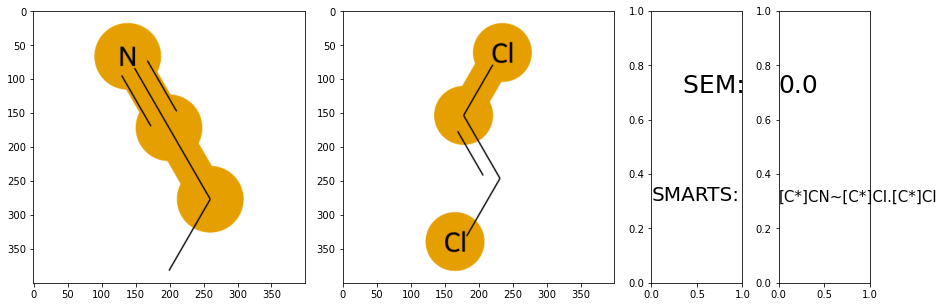

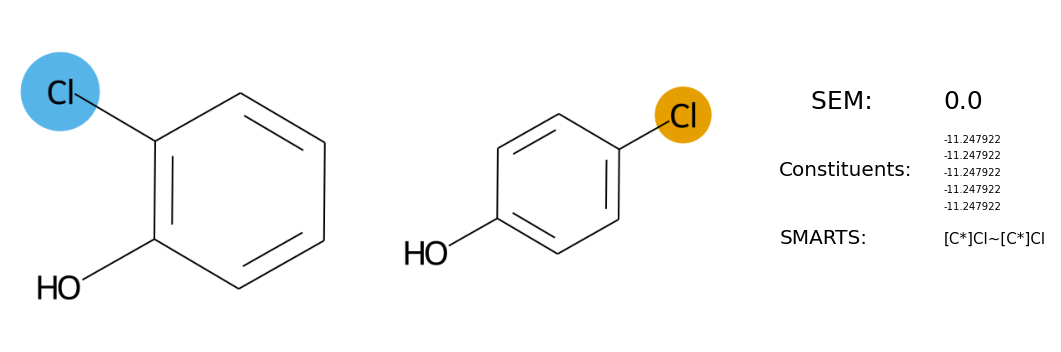

__________________________________________________________________________________________________________
mobley_7066554~mobley_1178614
mobley_1977493~mobley_2198613
./QUINTUP/29_dir_dir/finished/job_xil/sim_7/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_9/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_8/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_6/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_10/mobley_1977493~mobley_2198613/free


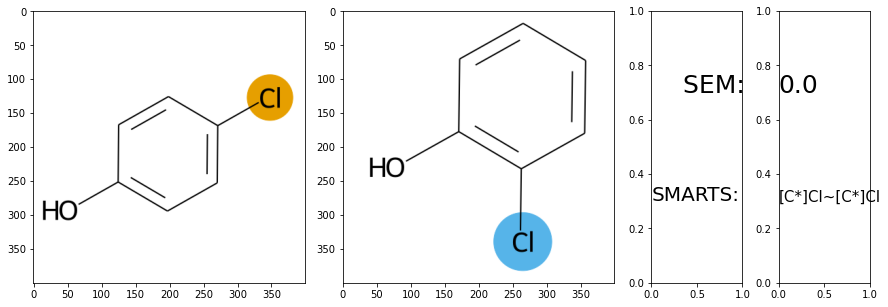

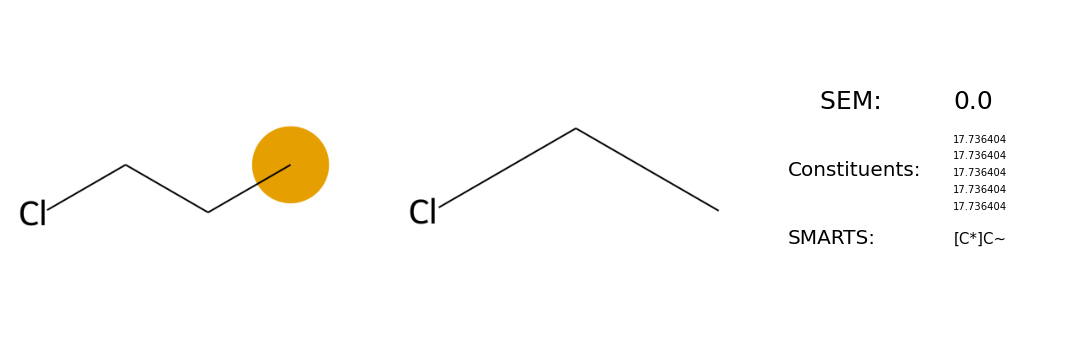

__________________________________________________________________________________________________________
mobley_2198613~mobley_1977493


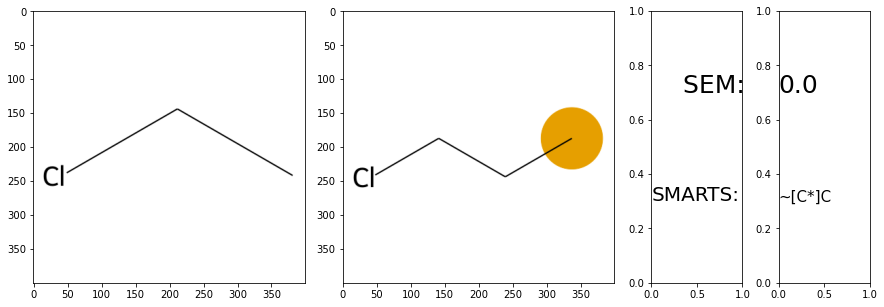

In [6]:
plot_perts(quints_infos[quints_infos["sem"] == 0.0].tail(10), precision=6)

# Lowest realistic SEMs:

mobley_1563176~mobley_2802855
./QUINTUP/29_dir_dir/finished/job_xcq/sim_14/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_13/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_12/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_15/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_11/mobley_1563176~mobley_2802855/free


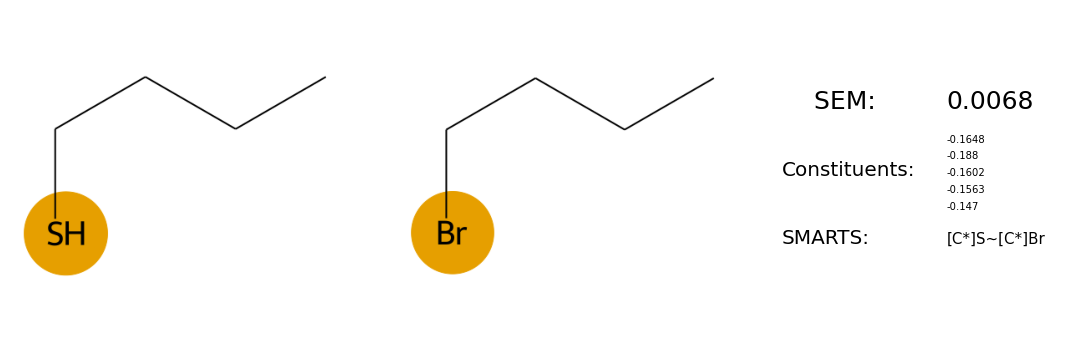

__________________________________________________________________________________________________________
mobley_2802855~mobley_1563176
mobley_1755375~mobley_5571660
./QUINTUP/29_dir_dir/finished/job_xej/sim_3/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_1/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_5/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_4/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_2/mobley_1755375~mobley_5571660/free


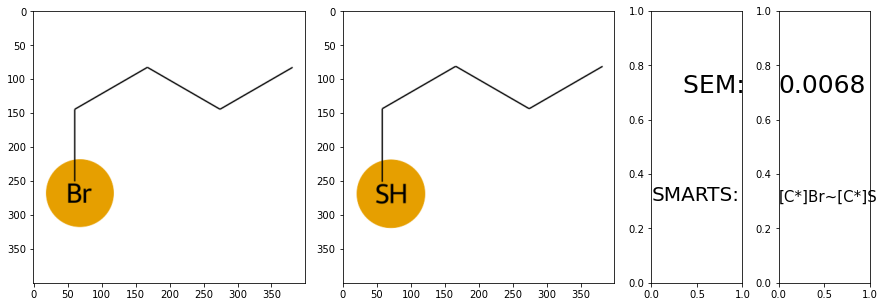

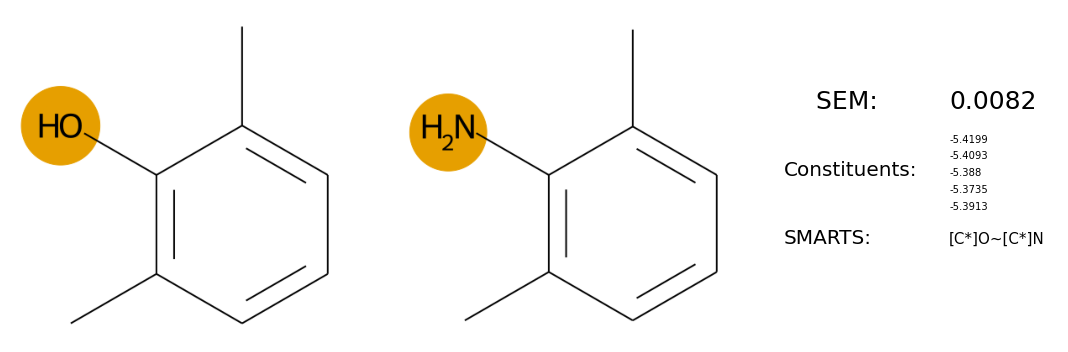

__________________________________________________________________________________________________________
mobley_5571660~mobley_1755375
mobley_186894~mobley_7708038
./QUINTUP/29_dir_dir/finished/job_xft/sim_3/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_1/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_5/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_4/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_2/mobley_186894~mobley_7708038/free


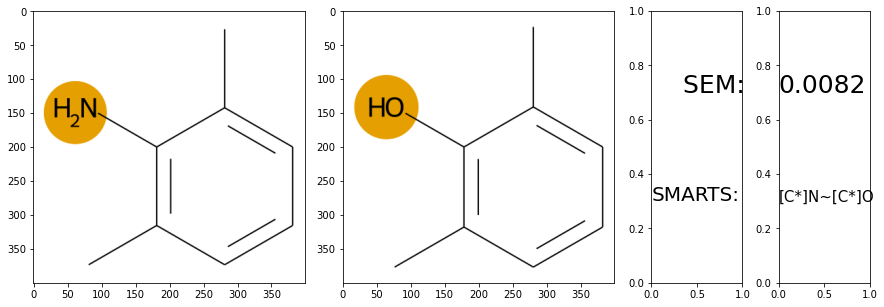

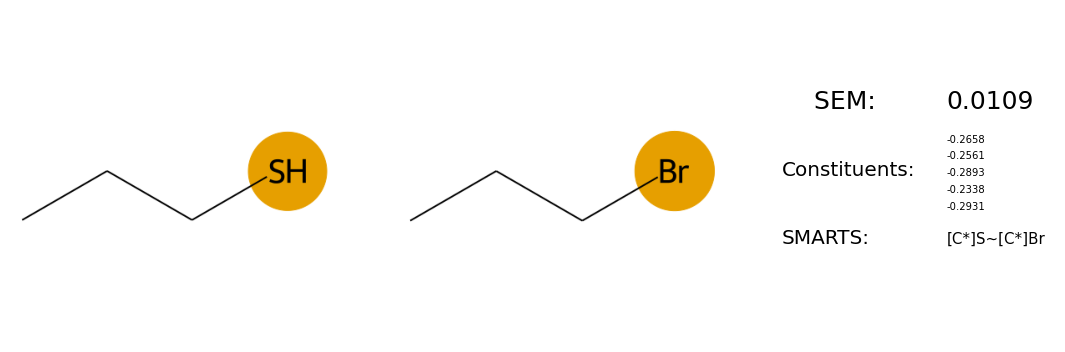

__________________________________________________________________________________________________________
mobley_7708038~mobley_186894
mobley_9733743~mobley_2422586
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_18/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_20/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_17/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_19/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_16/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_18/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_20/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_17/moble

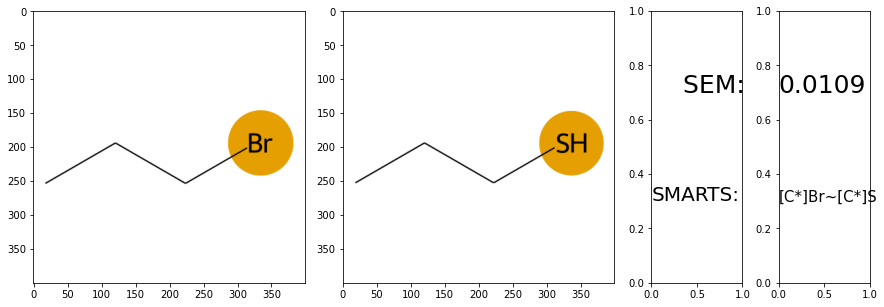

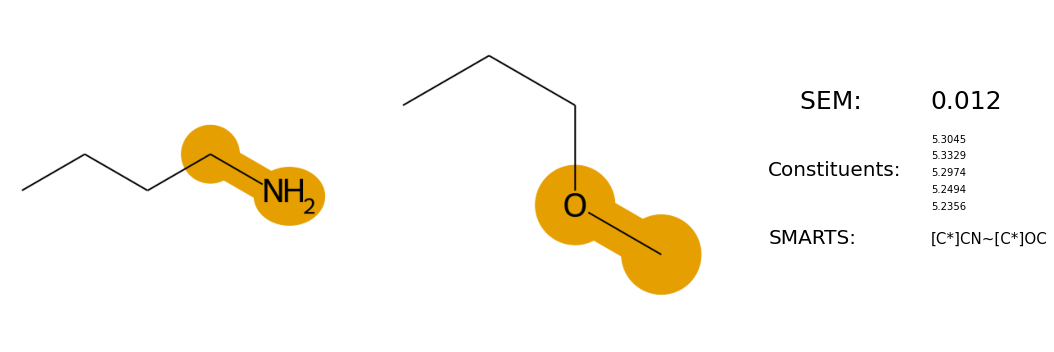

__________________________________________________________________________________________________________
mobley_2422586~mobley_9733743
mobley_1017962~mobley_7977115
./QUINTUP/24_dir_dir/round2/sim_194/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_191/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_192/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_193/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_195/mobley_1017962~mobley_7977115/free


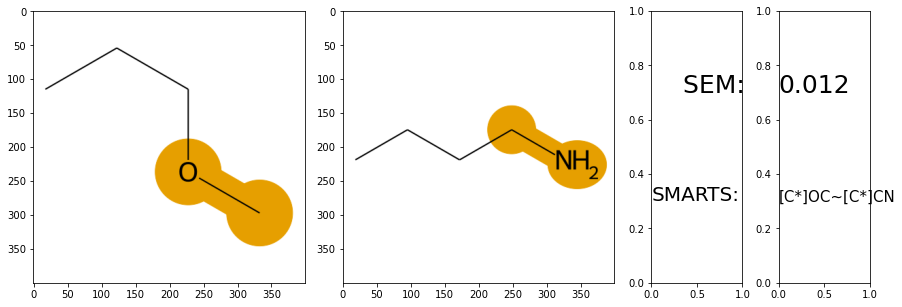

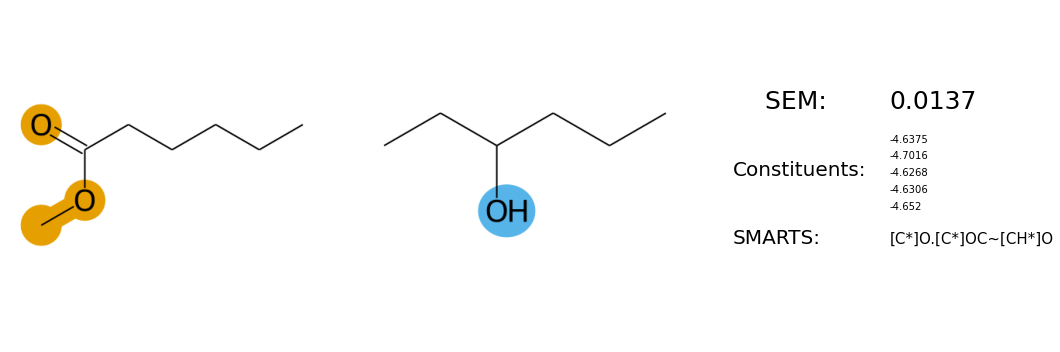

__________________________________________________________________________________________________________
mobley_7977115~mobley_1017962


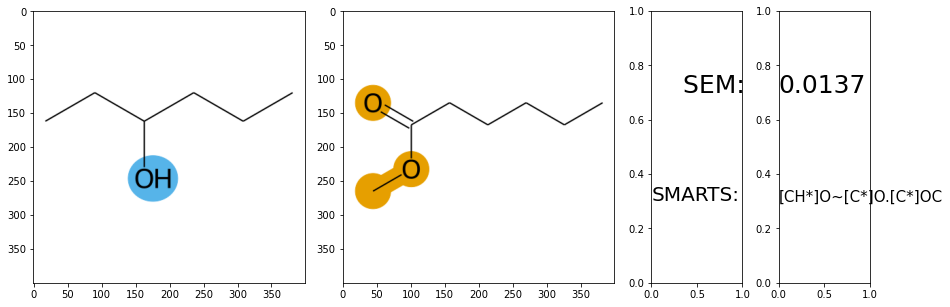

In [7]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sort_values(by="sem").head(10))

# Randomly picked realistic SEMs:

mobley_1755375~mobley_1571523
./QUINTUP/29_dir_dir/finished/job_xeg/sim_18/mobley_1755375~mobley_1571523/free
./QUINTUP/29_dir_dir/finished/job_xeg/sim_20/mobley_1755375~mobley_1571523/free
./QUINTUP/29_dir_dir/finished/job_xeg/sim_17/mobley_1755375~mobley_1571523/free
./QUINTUP/29_dir_dir/finished/job_xeg/sim_19/mobley_1755375~mobley_1571523/free
./QUINTUP/29_dir_dir/finished/job_xeg/sim_16/mobley_1755375~mobley_1571523/free


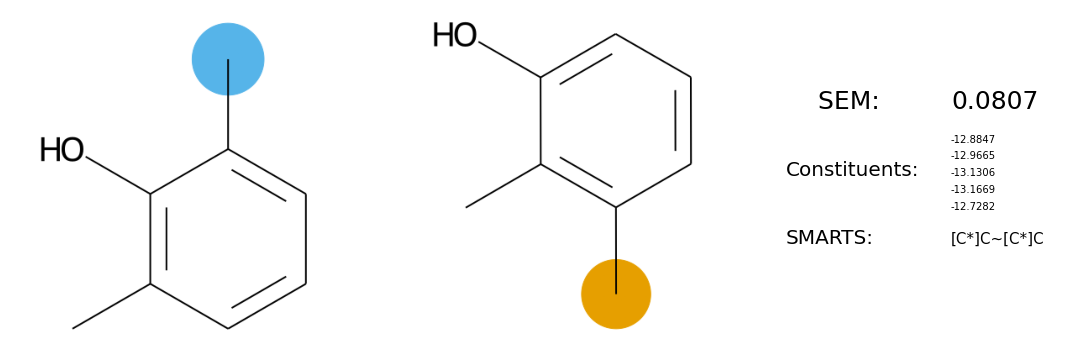

__________________________________________________________________________________________________________
mobley_1017962~mobley_1976156
./QUINTUP/21_dir_dir/round1/sim_34/mobley_1017962~mobley_1976156/free
./QUINTUP/21_dir_dir/round1/sim_33/mobley_1017962~mobley_1976156/free
./QUINTUP/21_dir_dir/round1/sim_31/mobley_1017962~mobley_1976156/free
./QUINTUP/21_dir_dir/round1/sim_35/mobley_1017962~mobley_1976156/free
./QUINTUP/21_dir_dir/round1/sim_32/mobley_1017962~mobley_1976156/free


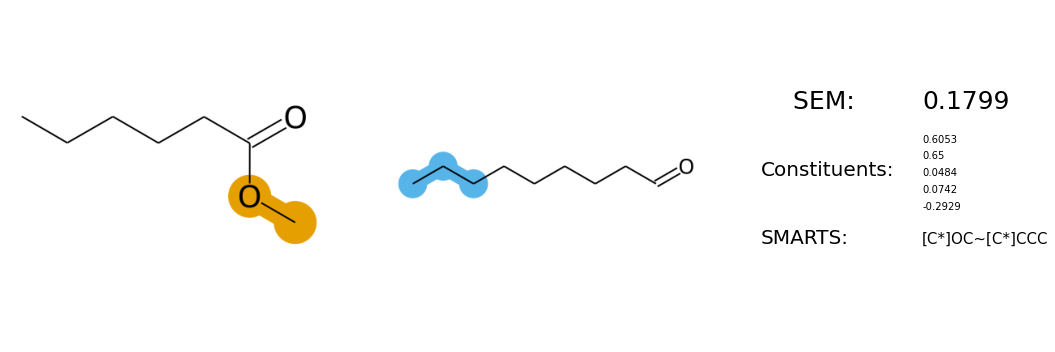

__________________________________________________________________________________________________________
mobley_9794857~mobley_1615431
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_18/mobley_9794857~mobley_1615431/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_20/mobley_9794857~mobley_1615431/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_17/mobley_9794857~mobley_1615431/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_19/mobley_9794857~mobley_1615431/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_16/mobley_9794857~mobley_1615431/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_18/mobley_9794857~mobley_1615431/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_20/mobley_9794857~mobley_1615431/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzd/sim_17/mobley_9794857~mobley_1615431/free

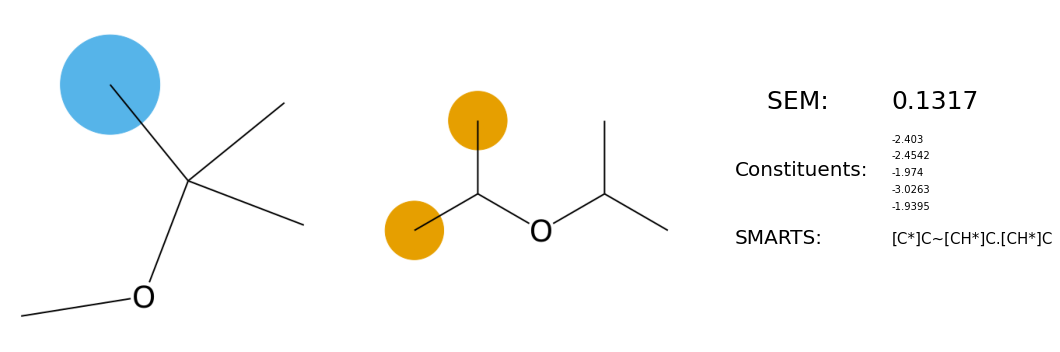

__________________________________________________________________________________________________________
mobley_8691603~mobley_1571523
mobley_2068538~mobley_1967551
./QUINTUP/29_dir_dir/finished/job_xji/sim_7/mobley_2068538~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_9/mobley_2068538~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_8/mobley_2068538~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_6/mobley_2068538~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_10/mobley_2068538~mobley_1967551/free


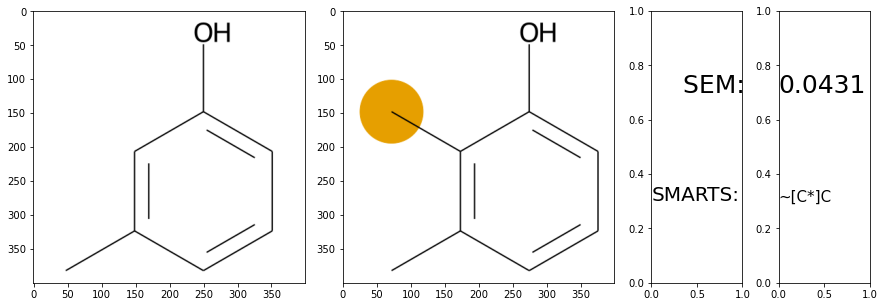

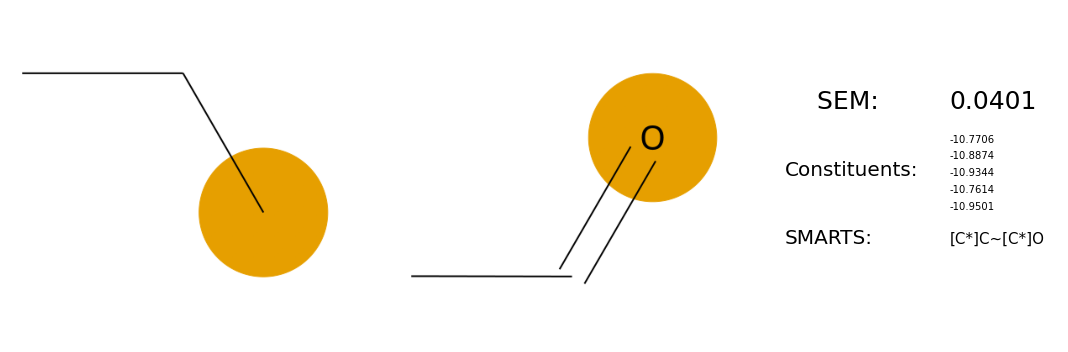

__________________________________________________________________________________________________________
mobley_1662128~mobley_4792268
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_2/mobley_1662128~mobley_4792268/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_0/mobley_1662128~mobley_4792268/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_3/mobley_1662128~mobley_4792268/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_3/mobley_1662128~mobley_4792268/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_1/mobley_1662128~mobley_4792268/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_2/mobley_1662128~mobley_4792268/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_0/mobley_1662128~mobley_4792268/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_3/mobley_1662128~mobley_4792268/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/jo

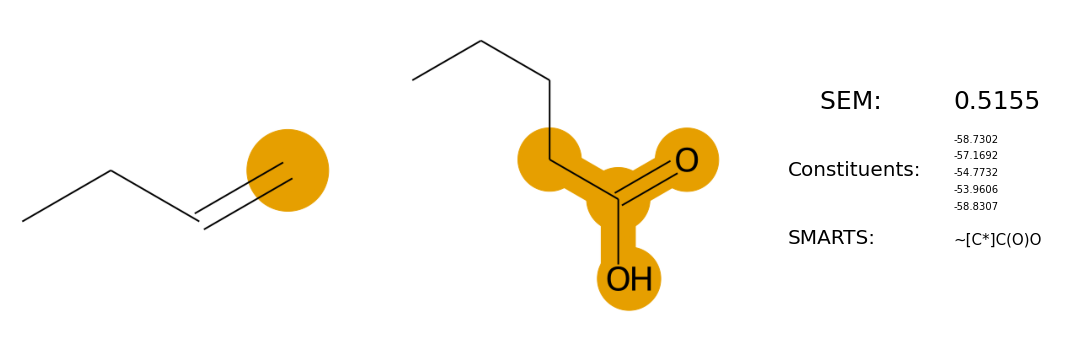

__________________________________________________________________________________________________________
mobley_6917738~mobley_1019269
mobley_1520842~mobley_2371092
./QUINTUP/29_dir_dir/finished/job_xcm/sim_3/mobley_1520842~mobley_2371092/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_1/mobley_1520842~mobley_2371092/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_5/mobley_1520842~mobley_2371092/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_4/mobley_1520842~mobley_2371092/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_2/mobley_1520842~mobley_2371092/free


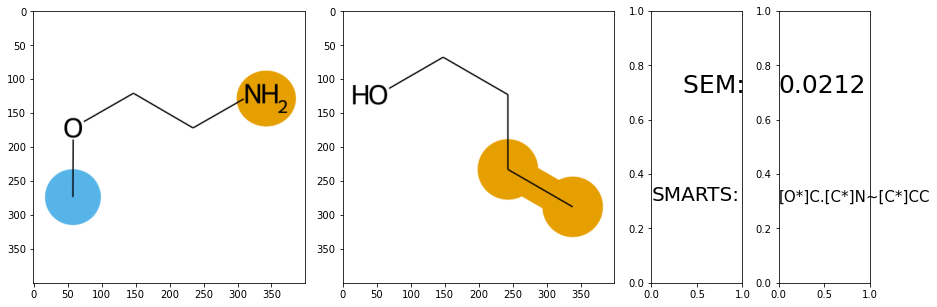

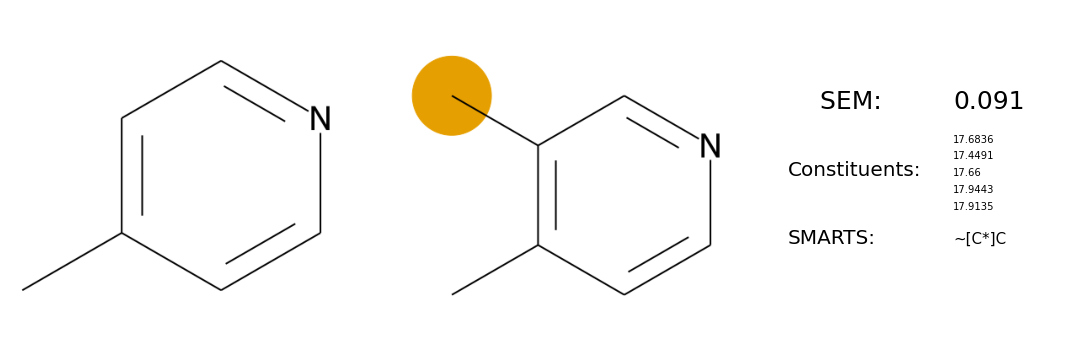

__________________________________________________________________________________________________________
mobley_3269565~mobley_1650157
mobley_4043987~mobley_627267
mobley_2043882~mobley_6175884
./QUINTUP/29_dir_dir/finished/job_xiy/sim_18/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_20/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_17/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_19/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_16/mobley_2043882~mobley_6175884/free


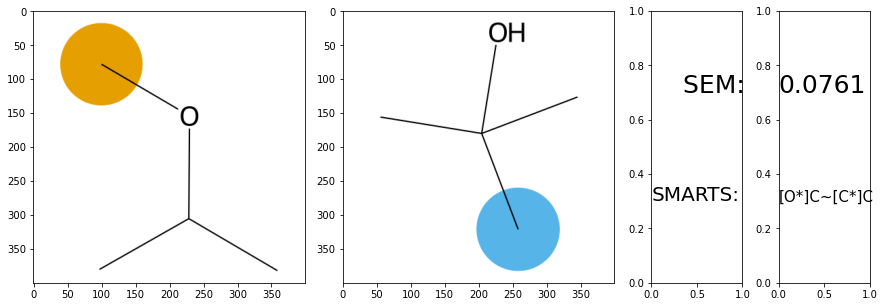

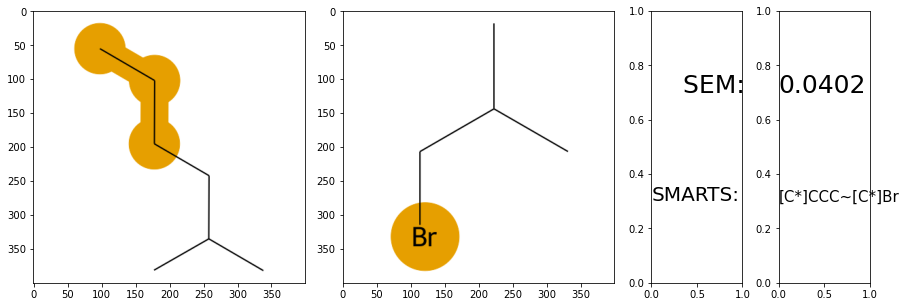

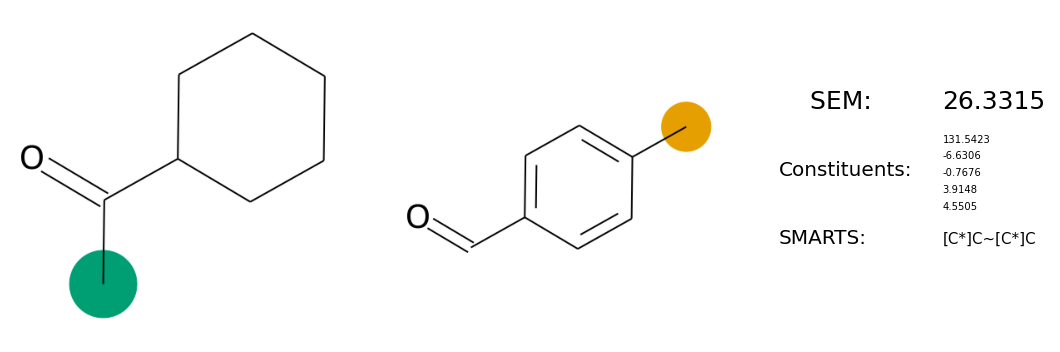

__________________________________________________________________________________________________________
mobley_2929847~mobley_1017962
mobley_9794857~mobley_8739734
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_7/mobley_9794857~mobley_8739734/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_9/mobley_9794857~mobley_8739734/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_8/mobley_9794857~mobley_8739734/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_6/mobley_9794857~mobley_8739734/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_10/mobley_9794857~mobley_8739734/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_7/mobley_9794857~mobley_8739734/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_9/mobley_9794857~mobley_8739734/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzn/sim_8/mobley_9794

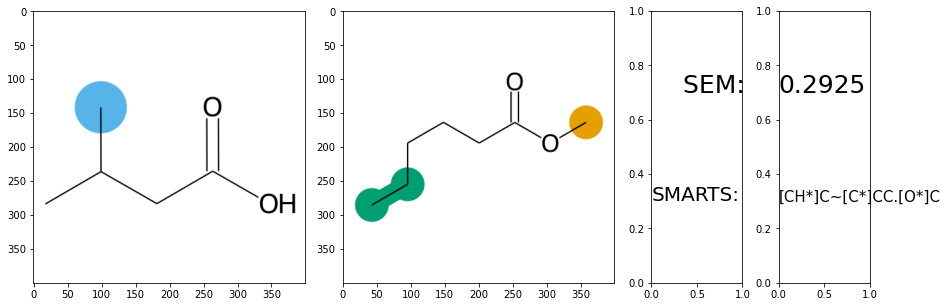

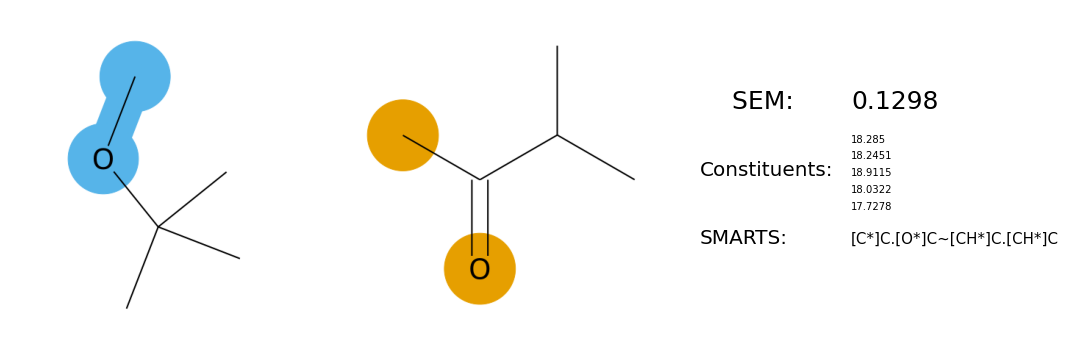

__________________________________________________________________________________________________________
mobley_2068538~mobley_1977493
./QUINTUP/29_dir_dir/finished/job_xji/sim_14/mobley_2068538~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_13/mobley_2068538~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_12/mobley_2068538~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_15/mobley_2068538~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xji/sim_11/mobley_2068538~mobley_1977493/free


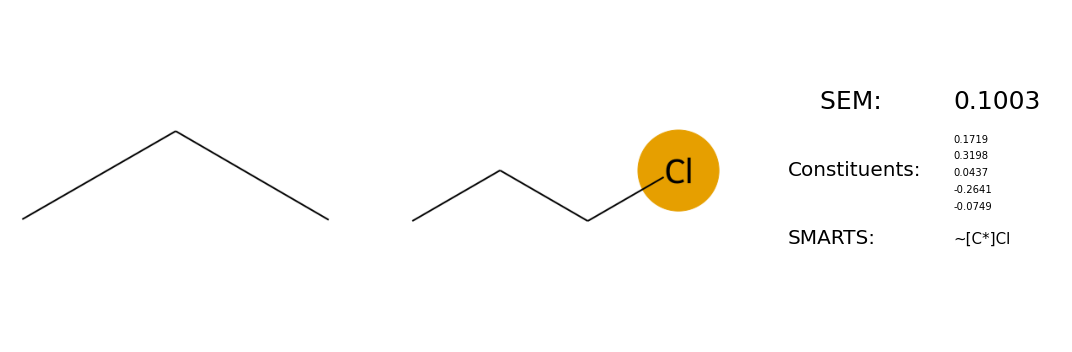

__________________________________________________________________________________________________________
mobley_1019269~mobley_7542832
./QUINTUP/24_dir_dir/round2/sim_499/mobley_1019269~mobley_7542832/free
./QUINTUP/24_dir_dir/round2/sim_498/mobley_1019269~mobley_7542832/free
./QUINTUP/24_dir_dir/round2/sim_497/mobley_1019269~mobley_7542832/free
./QUINTUP/24_dir_dir/round2/sim_500/mobley_1019269~mobley_7542832/free
./QUINTUP/24_dir_dir/round2/sim_496/mobley_1019269~mobley_7542832/free


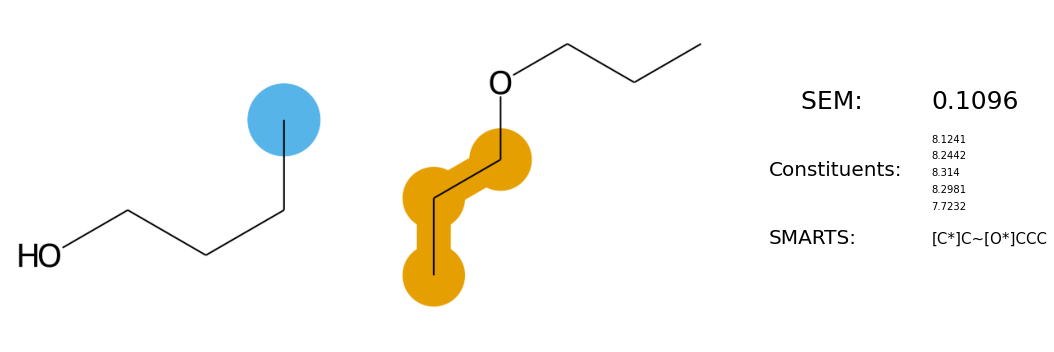

__________________________________________________________________________________________________________
mobley_9434451~mobley_8772587
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_7/mobley_9434451~mobley_8772587/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_9/mobley_9434451~mobley_8772587/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_8/mobley_9434451~mobley_8772587/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_6/mobley_9434451~mobley_8772587/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_10/mobley_9434451~mobley_8772587/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_7/mobley_9434451~mobley_8772587/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_9/mobley_9434451~mobley_8772587/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwn/sim_8/mobley_9434451~mobley_8772587/free
./MGZ_

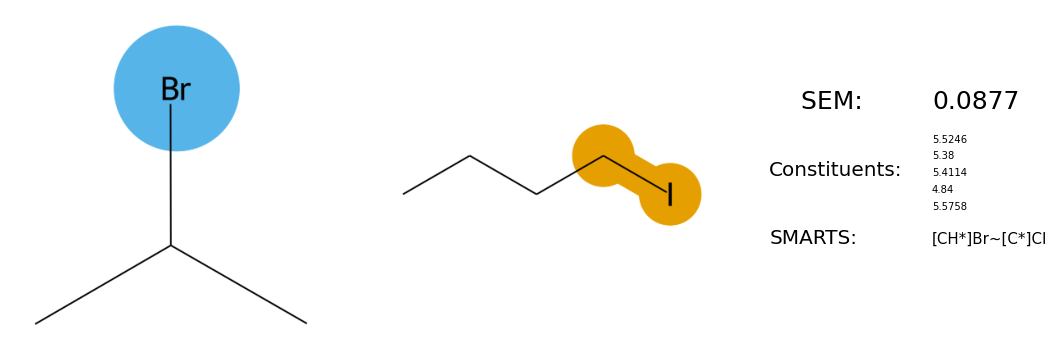

__________________________________________________________________________________________________________
mobley_1662128~mobley_7227357
./QUINTUP/30_dir_dir/finished/job_xih/sim_3/mobley_1662128~mobley_7227357/free
./QUINTUP/30_dir_dir/finished/job_xih/sim_1/mobley_1662128~mobley_7227357/free
./QUINTUP/30_dir_dir/finished/job_xih/sim_5/mobley_1662128~mobley_7227357/free
./QUINTUP/30_dir_dir/finished/job_xih/sim_4/mobley_1662128~mobley_7227357/free
./QUINTUP/30_dir_dir/finished/job_xih/sim_2/mobley_1662128~mobley_7227357/free


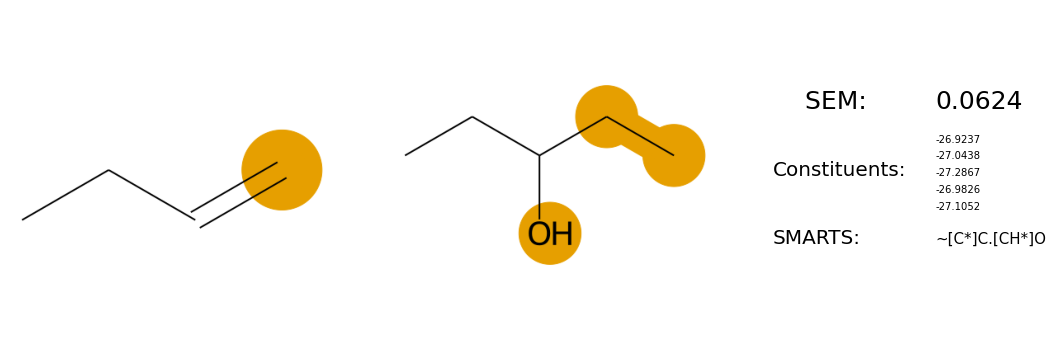

__________________________________________________________________________________________________________
mobley_1019269~mobley_7157427
./QUINTUP/25_dir_dir/round2/sim_461/mobley_1019269~mobley_7157427/free
./QUINTUP/25_dir_dir/round2/sim_463/mobley_1019269~mobley_7157427/free
./QUINTUP/25_dir_dir/round2/sim_462/mobley_1019269~mobley_7157427/free
./QUINTUP/25_dir_dir/round2/sim_465/mobley_1019269~mobley_7157427/free
./QUINTUP/25_dir_dir/round2/sim_464/mobley_1019269~mobley_7157427/free


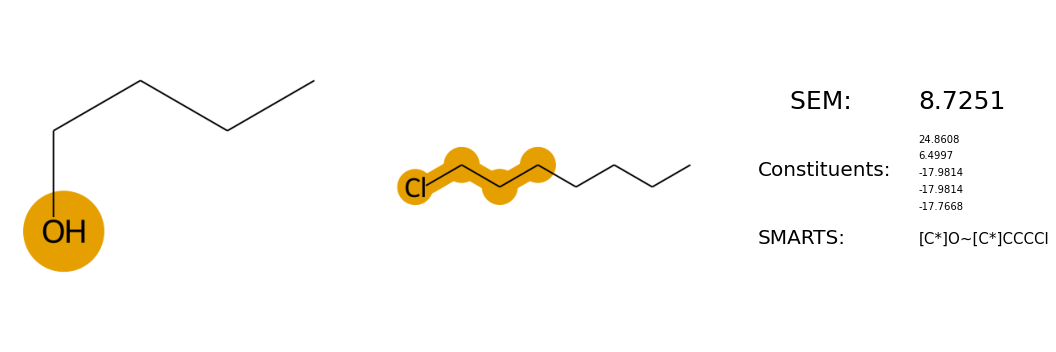

__________________________________________________________________________________________________________
mobley_6091882~mobley_1107178
mobley_9434451~mobley_9246351
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_7/mobley_9434451~mobley_9246351/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_9/mobley_9434451~mobley_9246351/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_8/mobley_9434451~mobley_9246351/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_6/mobley_9434451~mobley_9246351/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_10/mobley_9434451~mobley_9246351/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_7/mobley_9434451~mobley_9246351/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_9/mobley_9434451~mobley_9246351/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_8/mobley_9434

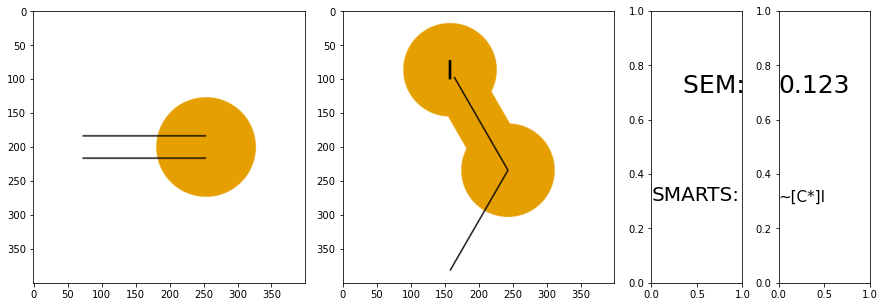

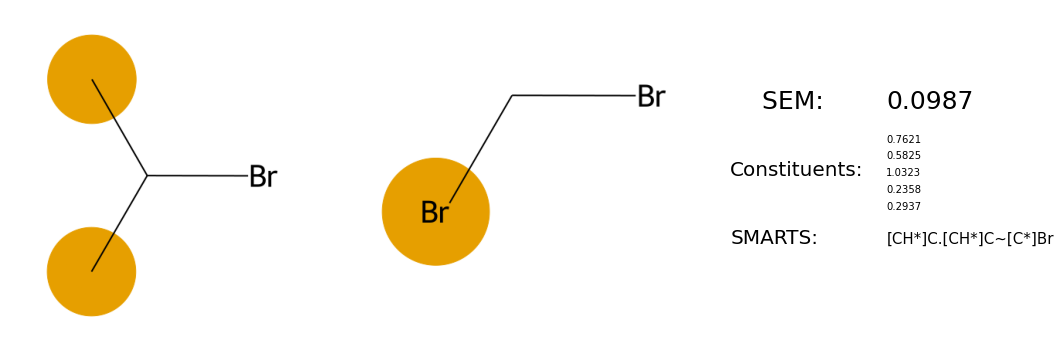

__________________________________________________________________________________________________________
mobley_9838013~mobley_2609604
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_3/mobley_9838013~mobley_2609604/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_1/mobley_9838013~mobley_2609604/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_5/mobley_9838013~mobley_2609604/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_4/mobley_9838013~mobley_2609604/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_2/mobley_9838013~mobley_2609604/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_3/mobley_9838013~mobley_2609604/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_1/mobley_9838013~mobley_2609604/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzs/sim_5/mobley_9838013~mobley_2609604/free
./MGZ_R

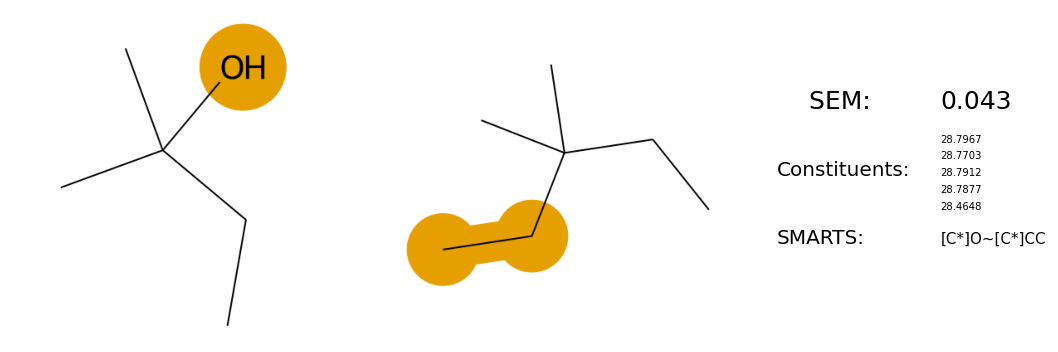

__________________________________________________________________________________________________________
mobley_2410897~mobley_1662128
mobley_2310185~mobley_1800170
mobley_1079207~mobley_1178614
./QUINTUP/29_dir_dir/finished/job_xas/sim_18/mobley_1079207~mobley_1178614/free
./QUINTUP/29_dir_dir/finished/job_xas/sim_20/mobley_1079207~mobley_1178614/free
./QUINTUP/29_dir_dir/finished/job_xas/sim_17/mobley_1079207~mobley_1178614/free
./QUINTUP/29_dir_dir/finished/job_xas/sim_19/mobley_1079207~mobley_1178614/free
./QUINTUP/29_dir_dir/finished/job_xas/sim_16/mobley_1079207~mobley_1178614/free


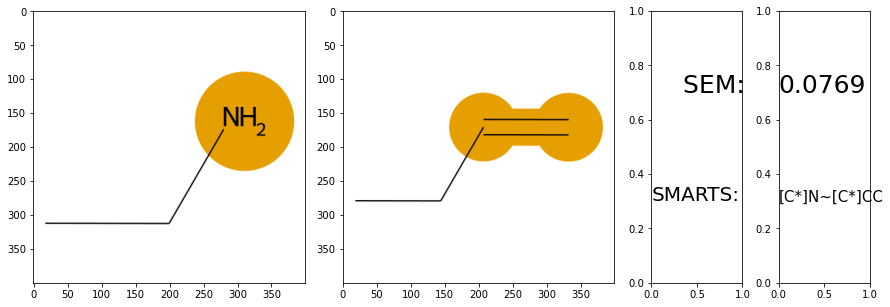

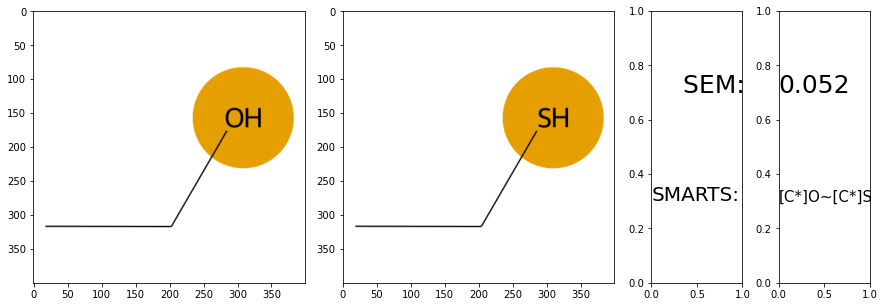

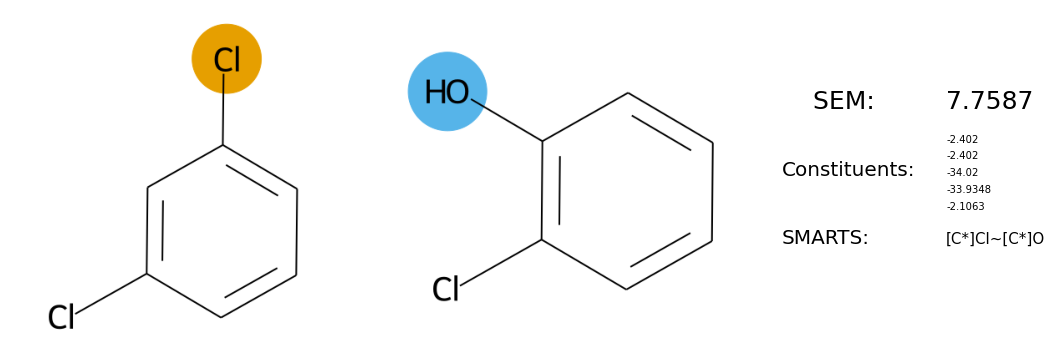

__________________________________________________________________________________________________________
mobley_2996632~mobley_1662128
mobley_2489709~mobley_1424265
mobley_9407874~mobley_6896128
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvz/sim_7/mobley_9407874~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvz/sim_9/mobley_9407874~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvz/sim_8/mobley_9407874~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvz/sim_6/mobley_9407874~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvz/sim_10/mobley_9407874~mobley_6896128/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvz/sim_7/mobley_9407874~mobley_6896128/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvz/sim_9/mobley_9407874~mobley_6896128/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform

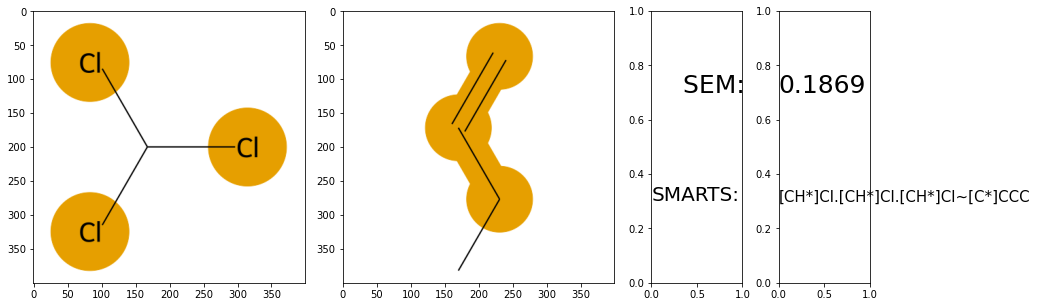

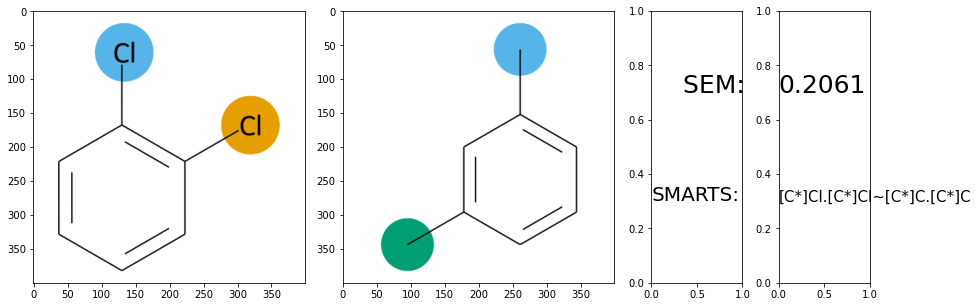

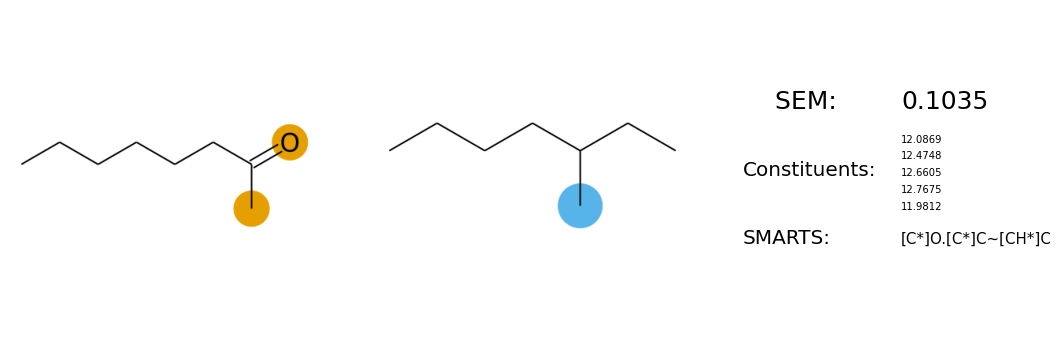

__________________________________________________________________________________________________________
mobley_3040612~mobley_1424265
mobley_4694328~mobley_8522124
mobley_1019269~mobley_766666
./QUINTUP/24_dir_dir/round2/sim_512/mobley_1019269~mobley_766666/free
./QUINTUP/24_dir_dir/round2/sim_513/mobley_1019269~mobley_766666/free
./QUINTUP/24_dir_dir/round2/sim_515/mobley_1019269~mobley_766666/free
./QUINTUP/24_dir_dir/round2/sim_511/mobley_1019269~mobley_766666/free
./QUINTUP/24_dir_dir/round2/sim_514/mobley_1019269~mobley_766666/free


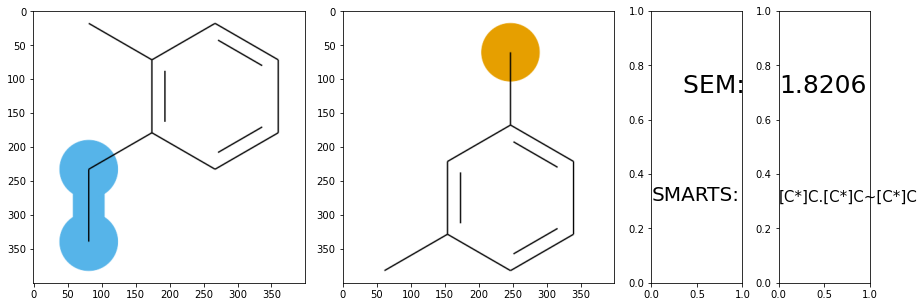

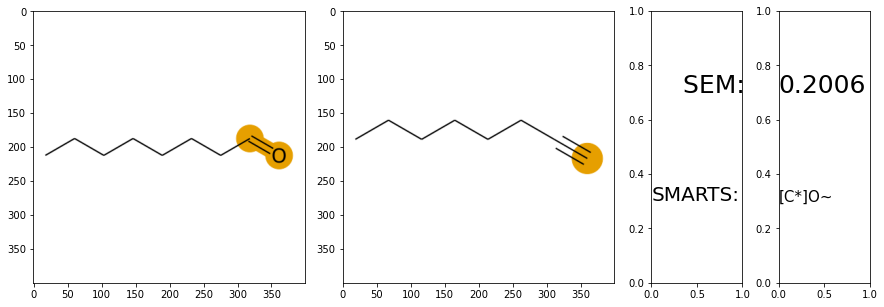

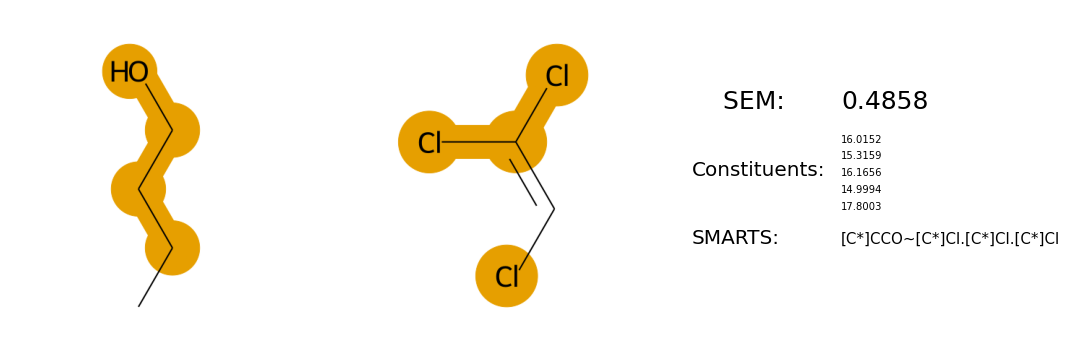

__________________________________________________________________________________________________________
mobley_9794857~mobley_2213823
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_18/mobley_9794857~mobley_2213823/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_20/mobley_9794857~mobley_2213823/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_17/mobley_9794857~mobley_2213823/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_19/mobley_9794857~mobley_2213823/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_16/mobley_9794857~mobley_2213823/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_18/mobley_9794857~mobley_2213823/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_20/mobley_9794857~mobley_2213823/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzf/sim_17/mobley_9794857~mobley_2213823/free

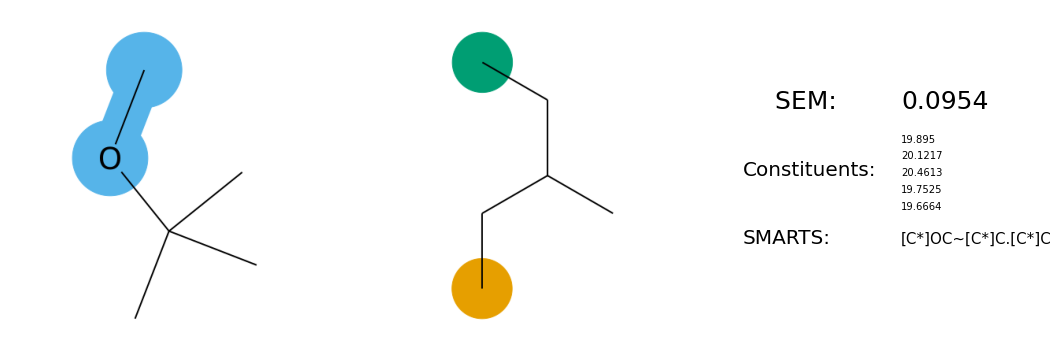

__________________________________________________________________________________________________________
mobley_2178600~mobley_9733743
mobley_1881249~mobley_7227357
./QUINTUP/29_dir_dir/finished/job_xgm/sim_18/mobley_1881249~mobley_7227357/free
./QUINTUP/29_dir_dir/finished/job_xgm/sim_20/mobley_1881249~mobley_7227357/free
./QUINTUP/29_dir_dir/finished/job_xgm/sim_17/mobley_1881249~mobley_7227357/free
./QUINTUP/29_dir_dir/finished/job_xgm/sim_19/mobley_1881249~mobley_7227357/free
./QUINTUP/29_dir_dir/finished/job_xgm/sim_16/mobley_1881249~mobley_7227357/free


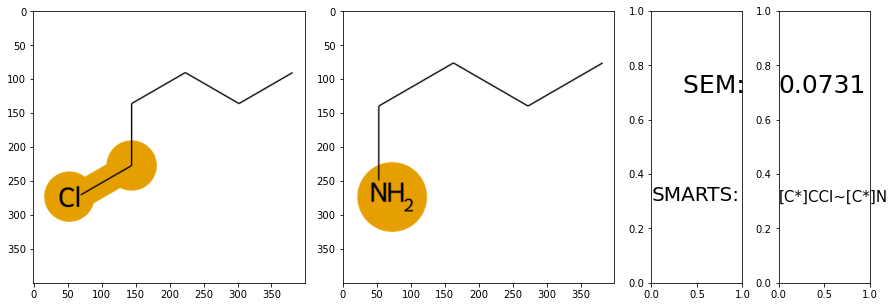

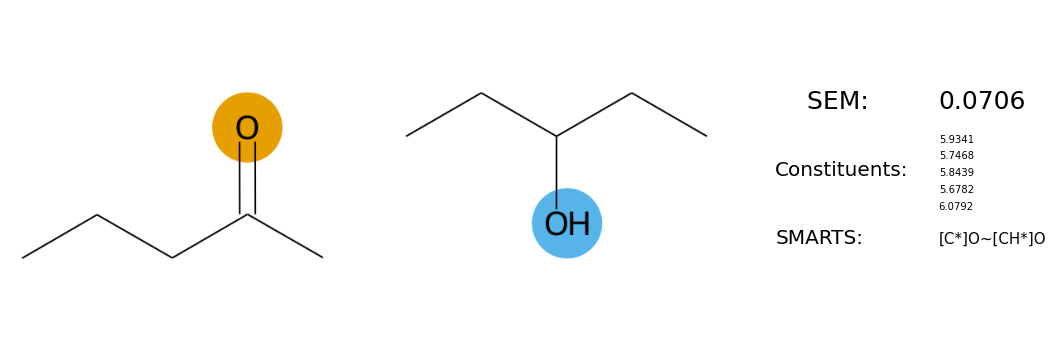

__________________________________________________________________________________________________________
mobley_1875719~mobley_1903702
mobley_9121449~mobley_1563176
mobley_1674094~mobley_6235784
./QUINTUP/30_dir_dir/finished/job_xir/sim_3/mobley_1674094~mobley_6235784/free
./QUINTUP/30_dir_dir/finished/job_xir/sim_1/mobley_1674094~mobley_6235784/free
./QUINTUP/30_dir_dir/finished/job_xir/sim_5/mobley_1674094~mobley_6235784/free
./QUINTUP/30_dir_dir/finished/job_xir/sim_4/mobley_1674094~mobley_6235784/free
./QUINTUP/30_dir_dir/finished/job_xir/sim_2/mobley_1674094~mobley_6235784/free


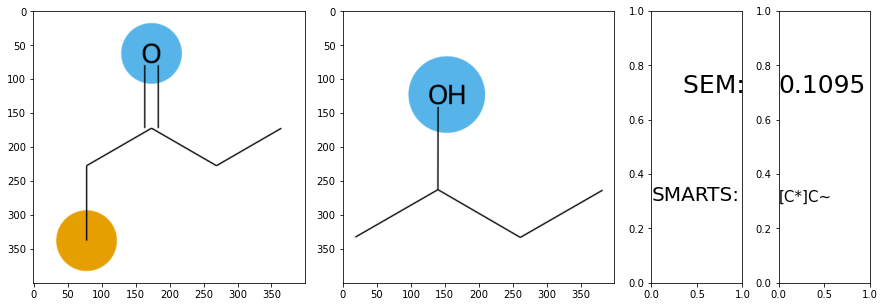

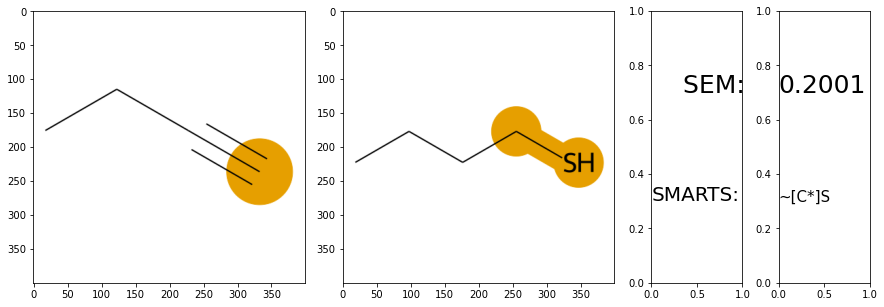

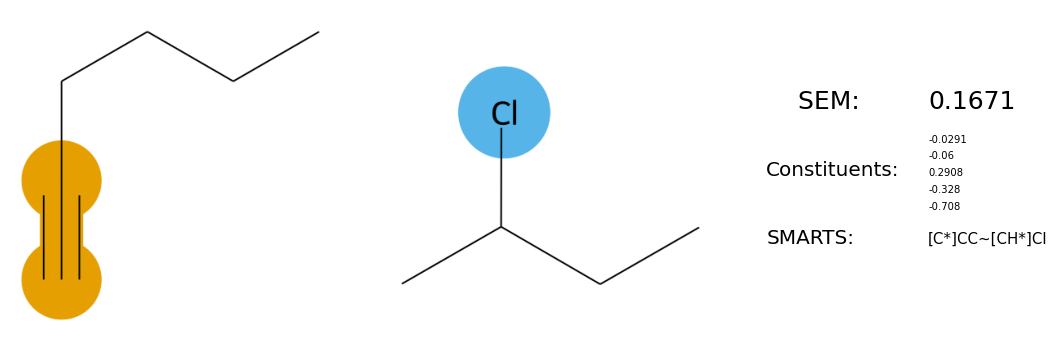

__________________________________________________________________________________________________________
mobley_430089~mobley_1875719
mobley_929676~mobley_4792268
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_7/mobley_929676~mobley_4792268/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_9/mobley_929676~mobley_4792268/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_8/mobley_929676~mobley_4792268/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_6/mobley_929676~mobley_4792268/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_10/mobley_929676~mobley_4792268/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_7/mobley_929676~mobley_4792268/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_9/mobley_929676~mobley_4792268/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_8/mobley_929676~mobley

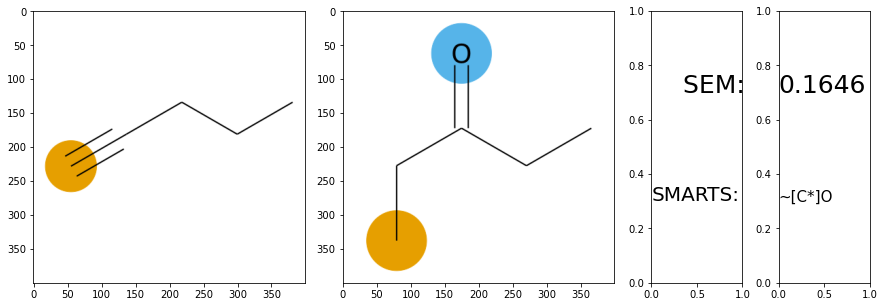

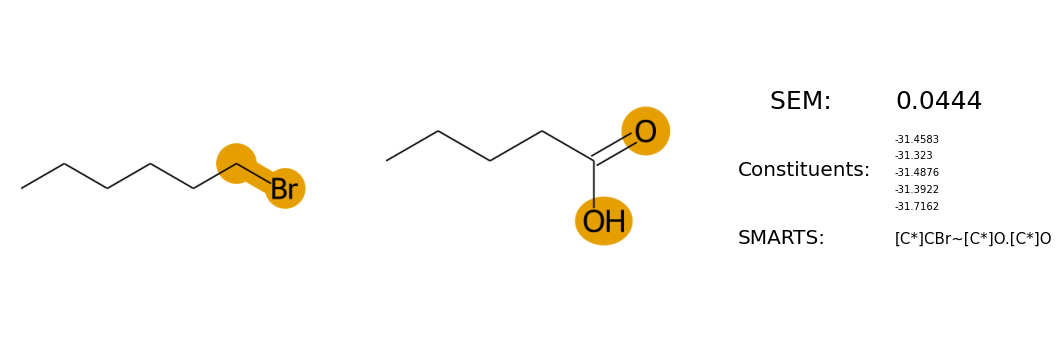

__________________________________________________________________________________________________________
mobley_1881249~mobley_1019269
./QUINTUP/29_dir_dir/finished/job_xgh/sim_7/mobley_1881249~mobley_1019269/free
./QUINTUP/29_dir_dir/finished/job_xgh/sim_9/mobley_1881249~mobley_1019269/free
./QUINTUP/29_dir_dir/finished/job_xgh/sim_8/mobley_1881249~mobley_1019269/free
./QUINTUP/29_dir_dir/finished/job_xgh/sim_6/mobley_1881249~mobley_1019269/free
./QUINTUP/29_dir_dir/finished/job_xgh/sim_10/mobley_1881249~mobley_1019269/free


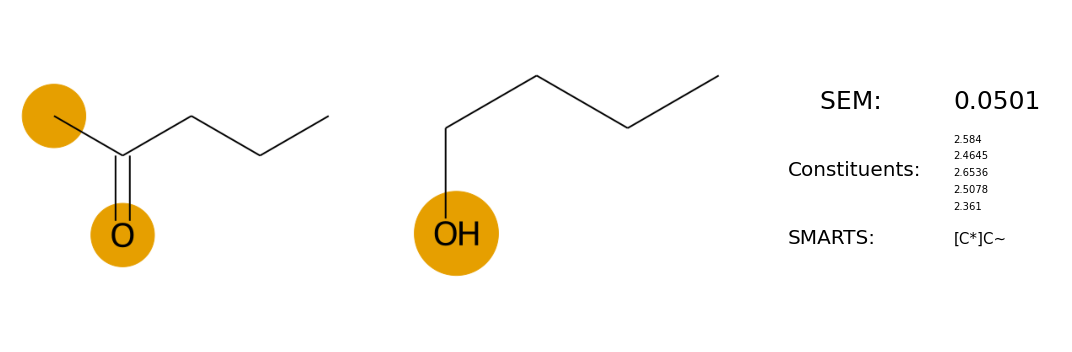

__________________________________________________________________________________________________________
mobley_9434451~mobley_9246215
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_3/mobley_9434451~mobley_9246215/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_1/mobley_9434451~mobley_9246215/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_5/mobley_9434451~mobley_9246215/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_4/mobley_9434451~mobley_9246215/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_2/mobley_9434451~mobley_9246215/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_3/mobley_9434451~mobley_9246215/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_1/mobley_9434451~mobley_9246215/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwo/sim_5/mobley_9434451~mobley_9246215/free
./MGZ_R

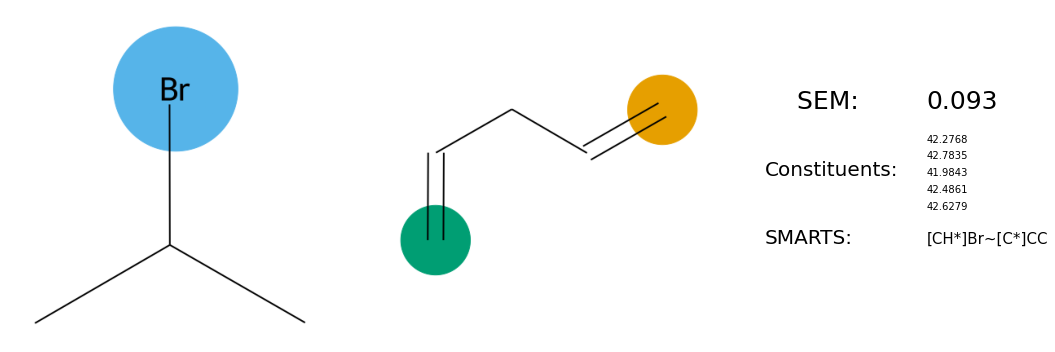

__________________________________________________________________________________________________________
mobley_1899443~mobley_1674094
./QUINTUP/29_dir_dir/finished/job_xgw/sim_3/mobley_1899443~mobley_1674094/free
./QUINTUP/29_dir_dir/finished/job_xgw/sim_1/mobley_1899443~mobley_1674094/free
./QUINTUP/29_dir_dir/finished/job_xgw/sim_5/mobley_1899443~mobley_1674094/free
./QUINTUP/29_dir_dir/finished/job_xgw/sim_4/mobley_1899443~mobley_1674094/free
./QUINTUP/29_dir_dir/finished/job_xgw/sim_2/mobley_1899443~mobley_1674094/free


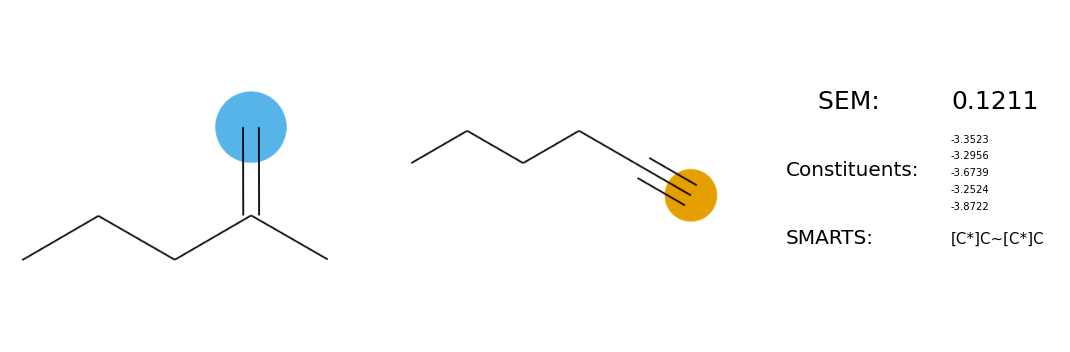

__________________________________________________________________________________________________________
mobley_1017962~mobley_5973402
./QUINTUP/22_dir_dir/round1/sim_146/mobley_1017962~mobley_5973402/free
./QUINTUP/22_dir_dir/round1/sim_147/mobley_1017962~mobley_5973402/free
./QUINTUP/22_dir_dir/round1/sim_150/mobley_1017962~mobley_5973402/free
./QUINTUP/22_dir_dir/round1/sim_149/mobley_1017962~mobley_5973402/free
./QUINTUP/22_dir_dir/round1/sim_148/mobley_1017962~mobley_5973402/free


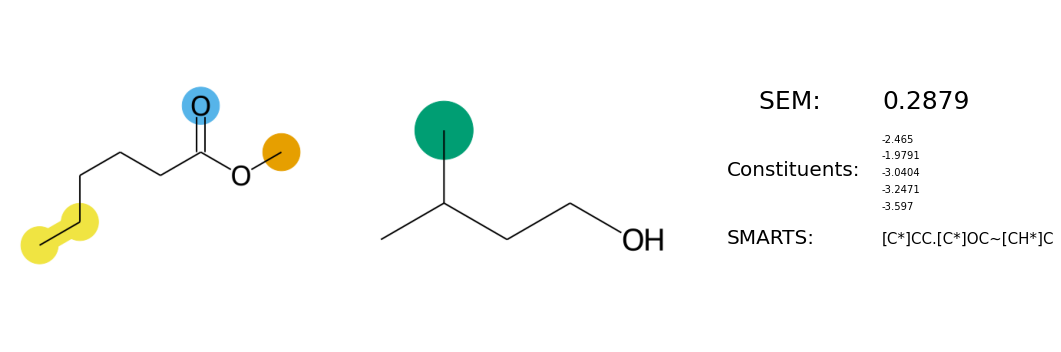

__________________________________________________________________________________________________________
mobley_1662128~mobley_7106722
./QUINTUP/30_dir_dir/finished/job_xig/sim_14/mobley_1662128~mobley_7106722/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_13/mobley_1662128~mobley_7106722/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_12/mobley_1662128~mobley_7106722/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_15/mobley_1662128~mobley_7106722/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_11/mobley_1662128~mobley_7106722/free


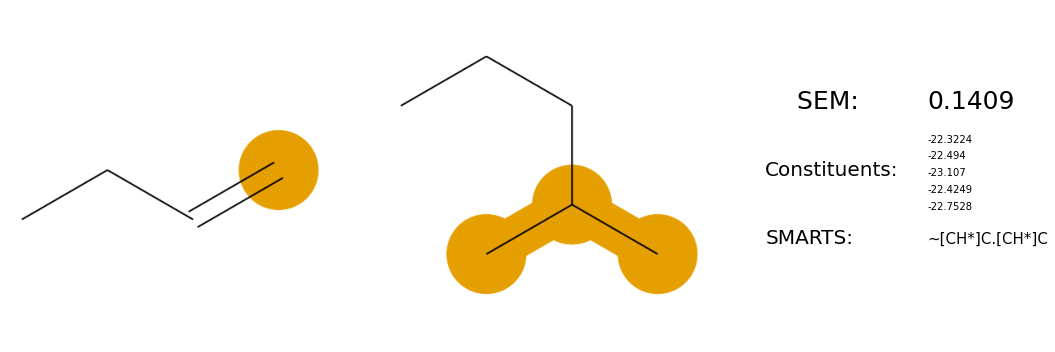

__________________________________________________________________________________________________________
mobley_4694328~mobley_9897248
mobley_9942801~mobley_2850833
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_14/mobley_9942801~mobley_2850833/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_13/mobley_9942801~mobley_2850833/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_12/mobley_9942801~mobley_2850833/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_15/mobley_9942801~mobley_2850833/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_11/mobley_9942801~mobley_2850833/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_14/mobley_9942801~mobley_2850833/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_13/mobley_9942801~mobley_2850833/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_12/mobl

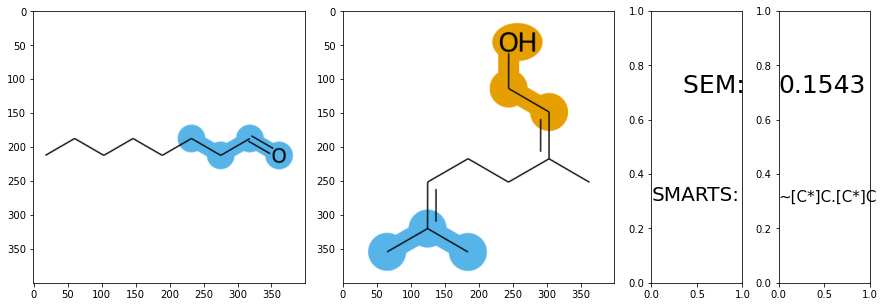

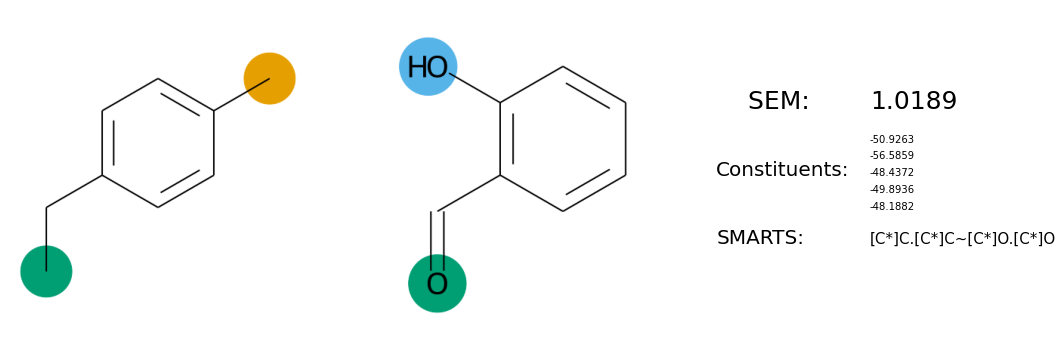

__________________________________________________________________________________________________________
mobley_129464~mobley_1019269
mobley_5094777~mobley_1728386
mobley_9121449~mobley_9112978


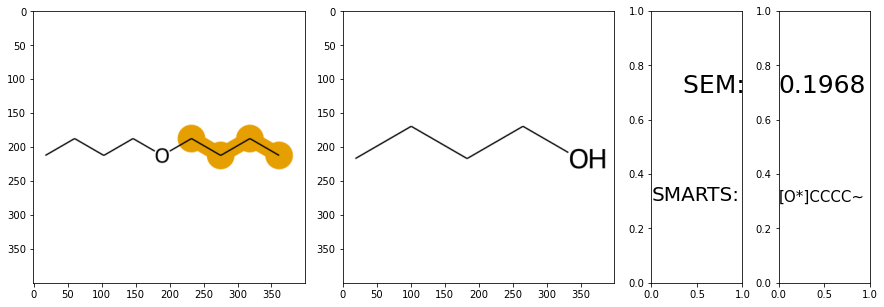

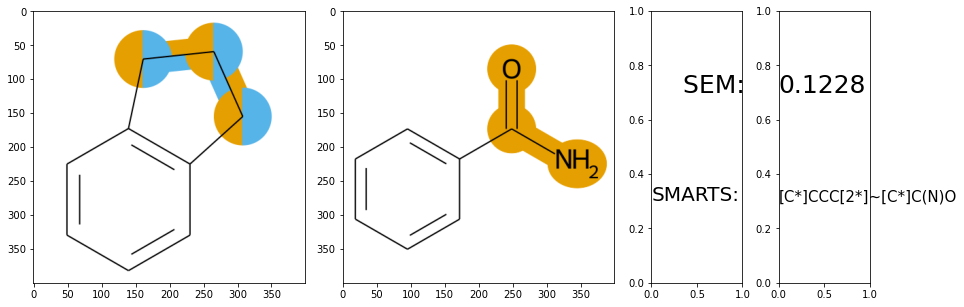

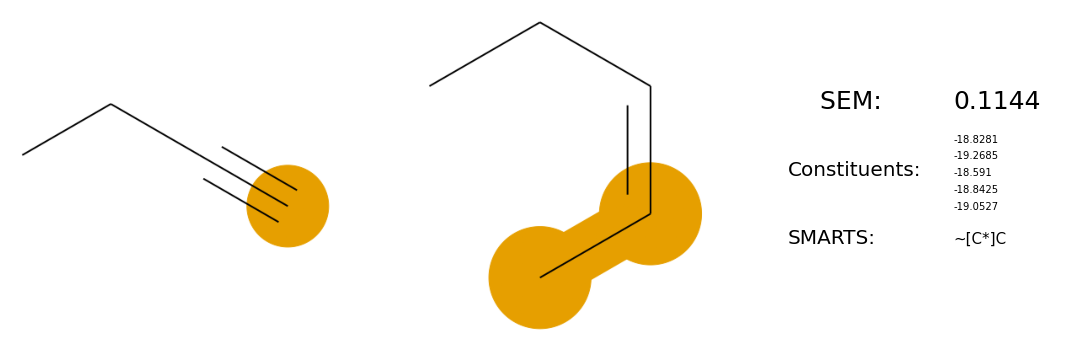

__________________________________________________________________________________________________________
mobley_1019269~mobley_8260524
./QUINTUP/30_dir_dir/finished/job_xat/sim_18/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_20/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_17/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_19/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_16/mobley_1019269~mobley_8260524/free


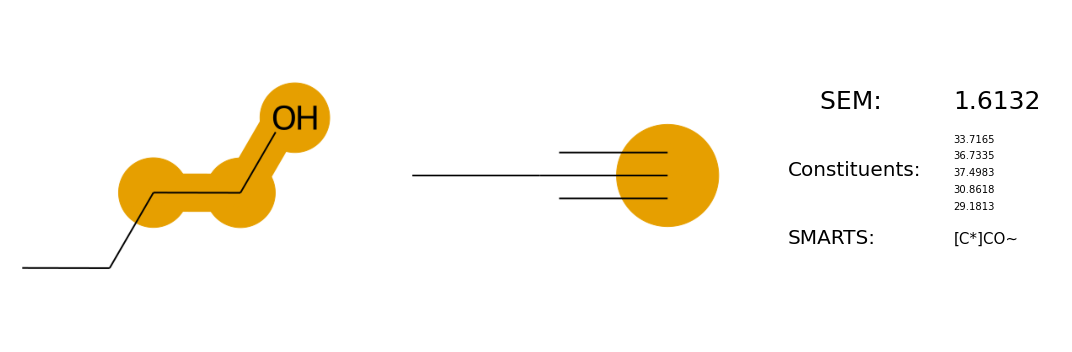

__________________________________________________________________________________________________________
mobley_1800170~mobley_7532833
./QUINTUP/29_dir_dir/finished/job_xet/sim_7/mobley_1800170~mobley_7532833/free
./QUINTUP/29_dir_dir/finished/job_xet/sim_9/mobley_1800170~mobley_7532833/free
./QUINTUP/29_dir_dir/finished/job_xet/sim_8/mobley_1800170~mobley_7532833/free
./QUINTUP/29_dir_dir/finished/job_xet/sim_6/mobley_1800170~mobley_7532833/free
./QUINTUP/29_dir_dir/finished/job_xet/sim_10/mobley_1800170~mobley_7532833/free


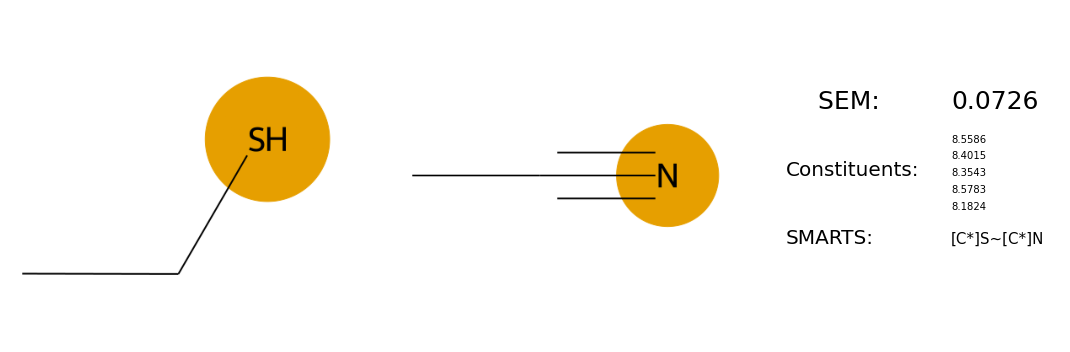

__________________________________________________________________________________________________________


In [8]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sample(50))